# Simple two-locus BDMI simulations

In [1]:
import sys, os
from functools import partial
import warnings
import numpy as np
import pandas as pd
from numpy.random import gamma
from numpy.random import beta
from scipy import stats
from tqdm.auto import trange, tqdm
from IPython.display import Markdown
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
import seaborn as sns
from vscodenb import set_vscode_theme
from vscodenb import vscode_theme as theme
set_vscode_theme(style='ticks')

try:
    import multiprocess
    POOL = multiprocess.Pool(multiprocess.cpu_count())
except ImportError:
    POOL = None

In [2]:
def simulate(*args,
            N1:int = 50000, N2:int = 50000, 
            M1:float = 0, M2:float = 0, 
            generations:int = 1000, 
            startmix:float = 0, init_pulse1:float = 0, init_pulse2:float = 0,
            # gamma_s=False,
            AB_bdmi_s:float=0, ab_bdmi_s:float=0,
            A_s:float = 0, B_s:float = 0, A2_s:float = 0, B2_s:float = 0, a_s:float = 0, b_s:float = 0, 
            AB_bdmi_dom:float = 0.5, A_dom:float = 0.5, B_dom:float = 0.5, 
            A2_freq:float = 0, B2_freq:float = 0,
            mig_interval=None,
            iteration=None,
            Ab_bdmi_s:float=0, aB_bdmi_s:float=0,
            Ab_bdmi_dom:float = 0.5, aB_bdmi_dom:float = 0.5):
    
    if startmix:
        assert not (init_pulse1 or init_pulse2), "don't mix startmix with init_pulse1 and init_pulse2"
        init_pulse1 = startmix
        init_pulse2 = startmix

    if callable(A2_freq):
        A2_freq = A2_freq()
    if callable(B2_freq):
        B2_freq = B2_freq()
    
    A_freq = 1-A2_freq
    B_freq = 1-B2_freq
    
    m1 = M1 / N1
    m2 = M2 / N2

    if callable(AB_bdmi_s):
        AB_bdmi_s = AB_bdmi_s()
    if callable(AB_bdmi_s):
        ab_bdmi_s = ab_bdmi_s()
    if callable(A_s):
        A_s = A_s()    
    if callable(A2_s):
        A2_s = A2_s()    
    if callable(a_s):
        a_s = a_s()    
    if callable(B_s):
        B_s = B_s()    
    if callable(B2_s):
        B2_s = B2_s()    
    if callable(b_s):
        b_s = b_s()        
    
    # if gamma_s:
    #     AB_bdmi_s = np.sign(AB_bdmi_s) * gamma(2, np.abs(AB_bdmi_s) / 2, 1)[0]
    #     # ab_bdmi_s = gamma(2, ab_bdmi_s / 2, 1)[0]
    #     # A_s = gamma(2, A_s / 2, 1)[0]
    #     # B_s = gamma(2, B_s / 2, 1)[0]
    #     # A2_s = gamma(2, A2_s / 2, 1)[0]
    #     # B2_s = gamma(2, B2_s / 2, 1)[0]
    #     # a_s = gamma(2, a_s / 2, 1)[0]
    #     # b_s = gamma(2, b_s / 2, 1)[0]
    
    data = np.empty((generations, 2, 6)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
        
    #                               A                       A2                      a                  B                       B2                      b
    data[0][0] = np.array([(1-init_pulse1)*A_freq, (1-init_pulse1)*(1-A_freq), init_pulse1,     init_pulse1*B_freq,     init_pulse1*(1-B_freq),     1-init_pulse1])
    data[0][1] = np.array([(init_pulse2)*A_freq,   (init_pulse2)*(1-A_freq),   (1-init_pulse2), (1-init_pulse2)*B_freq, (1-init_pulse2)*(1-B_freq), init_pulse2])

    for g in range(1, generations):
        # new generations
        for pop in range(2):
            
            if pop == 0: 
                N = N1
            else:
                N = N2
            
            f_A, f_A2, f_a, f_B, f_B2, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, 2*f_A*f_A2, 2*f_A2*f_a, f_A2*f_A2, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, 2*f_B*f_B2, 2*f_B2*f_b, f_B2*f_B2, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            x = 1 + AB_bdmi_s
            y = 1 + (AB_bdmi_s + AB_bdmi_dom * AB_bdmi_s) / 2
            u = 1 + (AB_bdmi_dom * AB_bdmi_s + AB_bdmi_dom * AB_bdmi_s) / 2
            AB_bdmi_sel = np.array([[x, y, y, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1]])
            x = 1 + ab_bdmi_s
            y = 1 + (ab_bdmi_s + (1-AB_bdmi_dom) * ab_bdmi_s) / 2
            u = 1 + ((1-AB_bdmi_dom) * ab_bdmi_s + (1-AB_bdmi_dom) * ab_bdmi_s) / 2            
            ab_bdmi_sel = np.array([[1, 1, 1, 1, 1, 1],
                                    [1, u, 1, u, 1, y],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, u, 1, u, 1, y],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, y, 1, y, 1, x]])

            bdmi_sel = np.multiply(AB_bdmi_sel, ab_bdmi_sel)

            x = 1 + Ab_bdmi_s
            y = 1 + (Ab_bdmi_s + Ab_bdmi_dom * Ab_bdmi_s) / 2
            u = 1 + (Ab_bdmi_dom * Ab_bdmi_s + Ab_bdmi_dom * Ab_bdmi_s) / 2
            Ab_bdmi_sel = np.array([[1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [x, y, y, 1, 1, 1]])
            bdmi_sel = np.multiply(bdmi_sel, Ab_bdmi_sel)


            x = 1 + aB_bdmi_s
            y = 1 + (aB_bdmi_s + aB_bdmi_dom * aB_bdmi_s) / 2
            u = 1 + (aB_bdmi_dom * aB_bdmi_s + aB_bdmi_dom * aB_bdmi_s) / 2
            aB_bdmi_sel = np.array([[1, 1, 1, y, y, x],
                                    [1, 1, 1, u, u, y],
                                    [1, 1, 1, u, u, y],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1]])

            bdmi_sel = np.multiply(bdmi_sel, aB_bdmi_sel)

            if pop == 0:
                a_sel = np.ones((6, 6))
                a_sel[(1, 3), :] = 1 + (1-A_dom) * a_s
                a_sel[5, :] = 1 + a_s                                
                B_sel = np.ones((6, 6))
                B_sel[:, 0] = 1 + B_s
                B_sel[:, (1, 2)] = 1 + (B_dom) * B_s                 
                B2_sel = np.ones((6, 6))
                B2_sel[:, (2, 3)] = 1 + (1-B_dom) * B2_s
                B2_sel[:, 4] = 1 + B2_s
                sel = np.multiply(np.multiply(bdmi_sel, a_sel), np.multiply(B_sel, B2_sel))
            else:
                b_sel = np.ones((6, 6))
                B2_sel[:, (1, 3)] = 1 + (1-B_dom) * b_s
                B2_sel[:, 5] = 1 + b_s                             
                A_sel = np.ones((6, 6))
                A_sel[0, :] = 1 + A_s
                A_sel[(1, 2), :] = 1 + (A_dom) * A_s                 
                A2_sel = np.ones((6, 6))
                A2_sel[(2, 3), :] = 1 + (1-A_dom) * A2_s
                A2_sel[4, :] = 1 + A2_s                                                
                sel = np.multiply(np.multiply(bdmi_sel, b_sel), np.multiply(A_sel, A2_sel))

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N, genotypes_sampling_prob.flatten()).reshape((6, 6))         
            
            f_A = counts[0, :].sum()*2 + counts[1, :].sum() + counts[2, :].sum()
            f_A2 = counts[4, :].sum()*2 + counts[2, :].sum() + counts[3, :].sum()
            f_a = counts[5, :].sum()*2 + counts[1, :].sum() + counts[3, :].sum()
            f_A, f_A2, f_a = f_A / (f_A + f_A2 + f_a), f_A2 / (f_A + f_A2 + f_a), f_a / (f_A + f_A2 + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum() + counts[:, 2].sum()
            f_B2 = counts[:, 4].sum()*2 + counts[:, 2].sum() + counts[:, 3].sum()
            f_b = counts[:, 5].sum()*2 + counts[:, 1].sum() + counts[:, 3].sum()
            f_B, f_B2, f_b = f_B / (f_B + f_B2 + f_b), f_B2 / (f_B + f_B2 + f_b), f_b / (f_B + f_B2 + f_b),

            new_freqs = np.array([f_A, f_A2, f_a, f_B, f_B2, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        if mig_interval is None or mig_interval[0] <= g < mig_interval[1]:
            data[g][0], data[g][1] = (1-m1)*data[g][0] + m1*data[g][1], (1-m2)*data[g][1] + m2*data[g][0]
   
    return data


def plot(data, 
        labels=['A', 'A2', 'a', 'B', 'B2', 'b'],
        pop1="Population 1",
        pop2="Population 2",
        # color1='#D96003',
        color1='#2FA04D',
        color2='#aaaaaa',
        # color2='#7570B3',
        axes=None,
        linewidth=1.5,
        alpha=1,
        xlabel='generation',
        ylabel='frequency',
        legend=True):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))    

    # axes[0].set_prop_cycle(color=[color1, color1, color2, color2, color2, color1], linestyle=['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed'])    
    # for x, label in zip(data[:, 0, :].transpose(), labels):
    #     axes[0].plot(x, label=label, linewidth=linewidth, alpha=alpha)
    # axes[1].set_prop_cycle(color=[color1, color1, color2, color2, color2, color1], linestyle=['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed'])    
    # for x, label in zip(data[:, 1, :].transpose(), labels):
    #     axes[1].plot(x, label=label, linewidth=linewidth, alpha=alpha)   

    colors = [color1, color1, color2, color2, color2, color1]
    linestyles = ['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed']
    for x, label, c, s in zip(data[:, 0, :].transpose(), labels, colors, linestyles):
        if np.sum(x) > 0:
            axes[0].plot(x, label=label, linewidth=linewidth, alpha=alpha, color=c, linestyle=s)
    for x, label, c, s in zip(data[:, 1, :].transpose(), labels, colors, linestyles):
        if np.sum(x) > 0:
            axes[1].plot(x, label=label, linewidth=linewidth, alpha=alpha, color=c, linestyle=s)

    # if not axes[1].get_legend():
    #     axes[1].legend(frameon=False, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5)) ;

    if legend:
        handles1, labels1 = axes[0].get_legend_handles_labels()
        tups = list(zip(labels1, handles1))
        tups = [t for t in tups if t[0] in ['A', 'A2', 'b']]
        _labels, _handles = zip(*sorted(dict(tups).items(), key=lambda x: labels.index(x[0])))
        axes[0].legend(_handles, _labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(handles1)) 

        handles2, labels2 = axes[1].get_legend_handles_labels()
        tups = list(zip(labels2, handles2))
        tups = [t for t in tups if t[0] in ['B', 'B2', 'a']]
        _labels, _handles = zip(*sorted(dict(tups).items(), key=lambda x: labels.index(x[0])))
        axes[1].legend(_handles, _labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(handles2)) 

        # labels, handles = zip(*sorted(dict(zip(labels1 + labels2, handles1 + handles2)).items(), key=lambda x: labels.index(x[0])))
        # axes[1].legend(handles, labels, frameon=False, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    axes[0].set_title(pop1, color=color1, fontweight='bold')
    axes[1].set_title(pop2, color=color2, fontweight='bold')
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel(ylabel)
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[0].set_xlim(left=0)
    axes[1].set_xlim(left=0)
    axes[0].set_ylim((-0.05, 1.05))
    axes[1].set_ylim((-0.05, 1.05))
    axes[0].axhline(y=0, linewidth=0.2, color='black')
    axes[0].axhline(y=1, linewidth=0.2, color='black')
    axes[1].axhline(y=0, linewidth=0.2, color='black')
    axes[1].axhline(y=1, linewidth=0.2, color='black')

    # ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
    # ax1.axhline(y=startmix, linestyle='dotted', color='black')
    # axes[1].axhline(y=1-startmix, linestyle='dotted', color='black')
    # axes[1].axhline(y=startmix, linestyle='dotted', color='black')
    plt.tight_layout()
    sns.despine()
    return axes#(ax1, ax2)

def plot_simulation(replicates=1, plot_kwargs={},  **sim_kwargs):
    from functools import partial
    fun = partial(simulate, **sim_kwargs)
    tensor = np.stack([fun(iteration=1) for _ in range(replicates)])  
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    kwargs = plot_kwargs.copy()
    kwargs['axes'] = axes
    tensor_means = np.mean(tensor, axis=0)
    plot(tensor_means, **kwargs)
    if replicates > 1:
        kwargs['linewidth'] = 0.3
        kwargs['legend'] = False
        plot(tensor_means, **kwargs)
        for i in range(tensor.shape[0]):
            plot(tensor[i,:,:,:], **kwargs)
    plt.show()
    return None

# Model

## Two loci with two alleles

- Standard BDMI case with incompatible derived alleles A and B

```
       Population 1                   Population 2
       
          1   2                          1   2
        --A---b--                      --a---B--    
        --A---b--                      --a---B--   
                          
    A fixed, b fixed                a fixed, B fixed
```

## Two loci with three alleles

- Variant including A2 and B2. 
- A2 can represent another derived allele originatig in population 1
- A2 can also be made to represent the ancestral a-allele in population 1 (if you sum simulated a and A2 frequences.
- Same applies to B2

```
          1   2                          1   2
        --A---b--                      --a---B--    
        --A2--b--                      --a---B2-   
                          
A, A2 segregating, b fixed     a fixed, B, B2 segregating
```

---

## Population parameters

- `generations = 1000`: Number of generations simulated.
- `N1 = 30000`: Size of population 1.
- `N2 = 30000`: Size of population 2.
- `M1 = 0`: Migrants recieved in population 1 in each generation.
- `M2 = 0`: Migrants recieved in population 2 in each generation.
- `init_pulse1 = 0`: Initial migrant frequency in population 1.
- `init_pulse2 = 0`: Initial migrant frequency in population 2.
- `A2_freq = 0`: Frequency of A2 allele (0 imples an A frequency of 1).
- `B2_freq = 0`: Frequency of B2 allele (0 imples an B frequency of 1).

---

## Selection and dominance parameters
    
- `AB_bdmi_s = 0`: Selection on genotypes with both A and B,
- `ab_bdmi_s = 0`: Selection on genotypes with both A and B,
- `A_s = 0`: Independent selection on A.
- `A2_s = 0`: Independent selection on A2.
- `a_s = 0`: Independent selection on a.           
- `B_s = 0`: Independent selection on B.
- `B2_s = 0`: Independent selection on B2.
- `b_s = 0`: Independent selection on b.
- `AB_bdmi_dom = 0.5`: Dominance of AB haplotype.
- `A_dom = 0.5`: Dominance of A allele.
- `B_dom = 0.5`: Dominance of B allele.

---

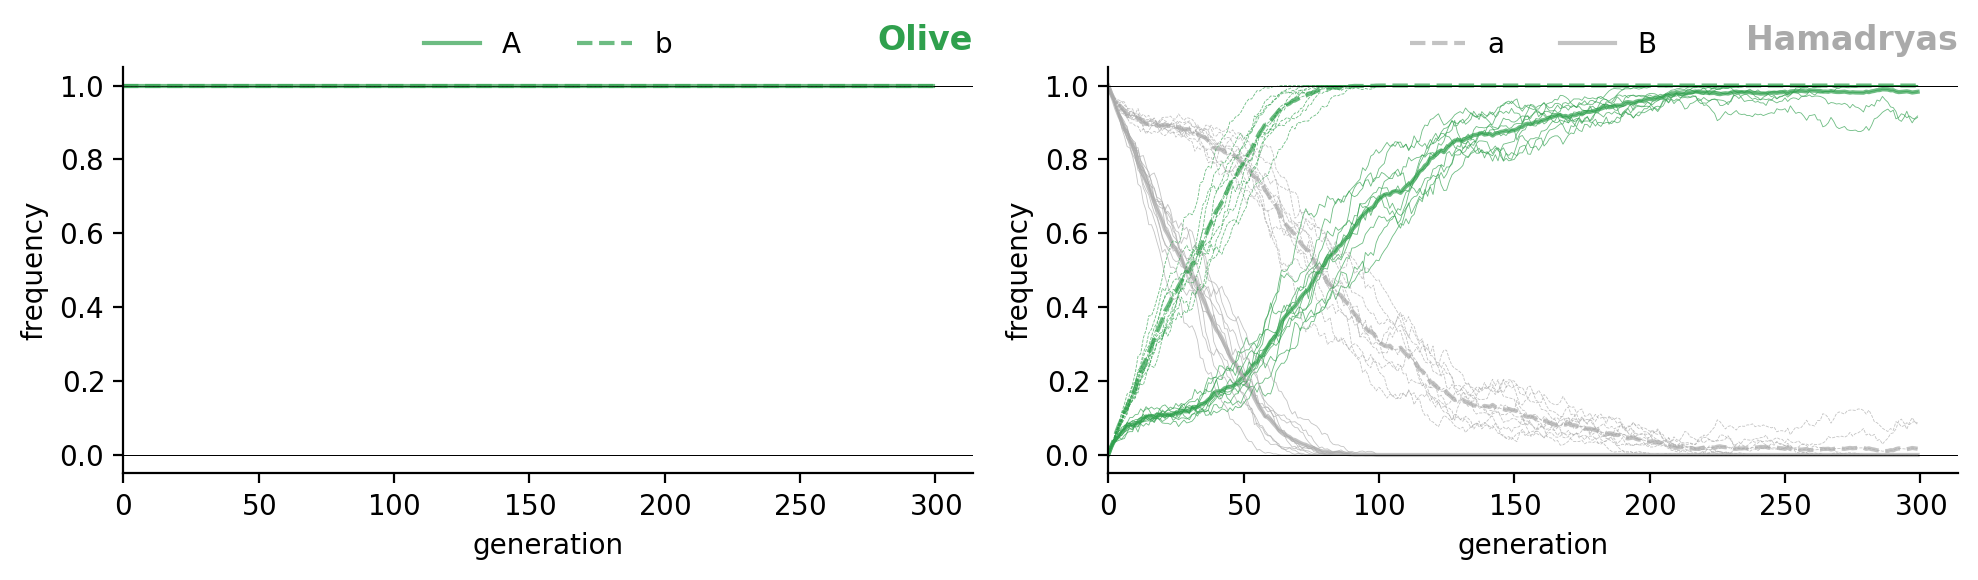

In [3]:
plot_kwargs = dict(pop1='Olive', pop2='Hamadryas', linewidth=1.5, alpha=0.7)

sim_params = dict(
    generations=300, N1=500, N2=500, M1=0, M2=10, init_pulse1=0, init_pulse2=0,
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5, A2_freq=0, B2_freq=0, A2_s=0, B2_s=0, 
    A_s=0, B_s=0, a_s=0, b_s=0, AB_bdmi_s=-0.3, ab_bdmi_s=-0
)

sim = partial(plot_simulation, replicates=10, plot_kwargs=plot_kwargs, generations=300, N1=500, N2=500)
sim(M2=10, AB_bdmi_s=-0.3)

## BDMI scenario to explain ECH observations

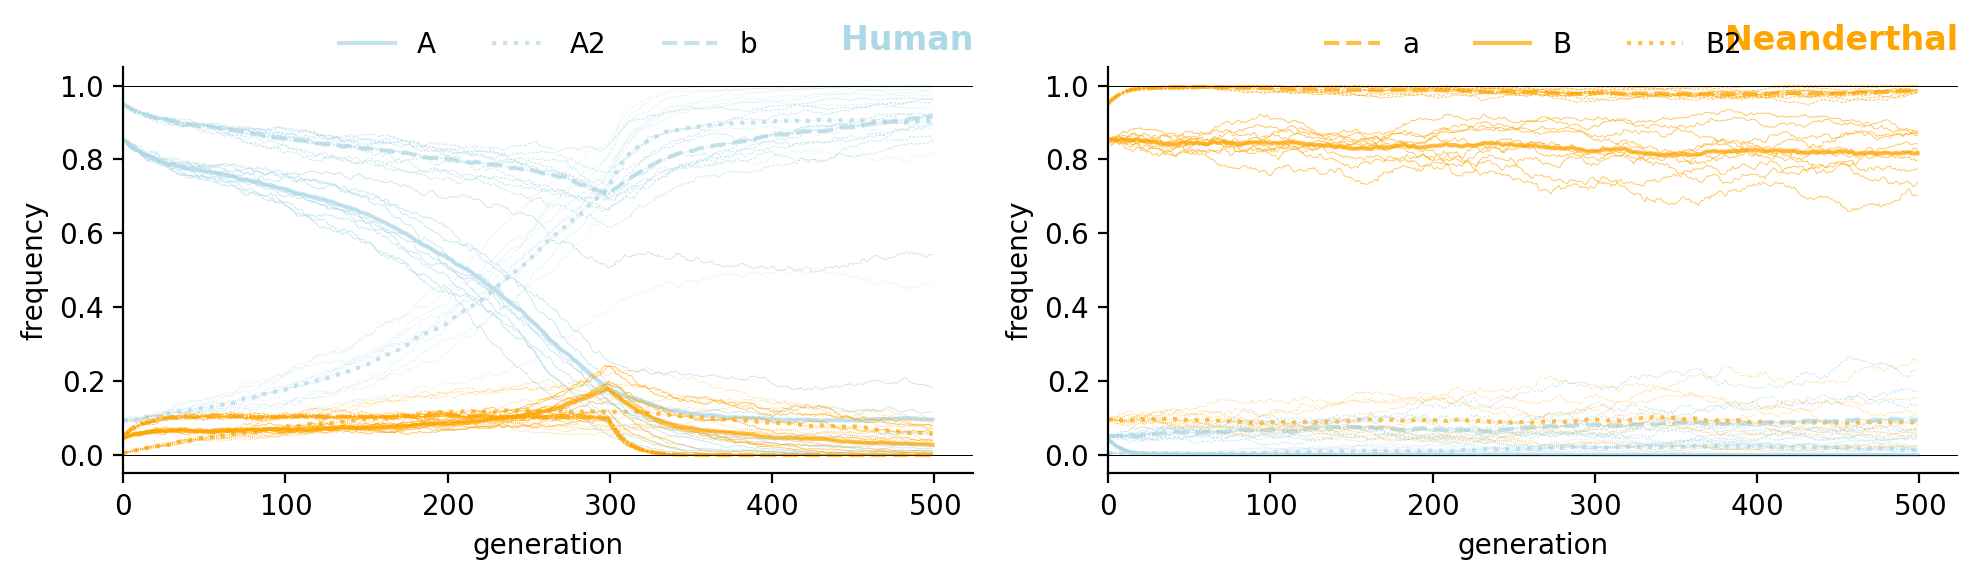

In [5]:
plot_kwargs = dict(pop1='Human', pop2='Neanderthal', color1='lightblue', color2='orange', linewidth=1.5, alpha=0.7)


startmix = 0.05 # some fast initial admixture
plot_simulation(replicates=10,
                N1=10000, N2=5000, 
                M1=100, M2=1,       # unidirectional migration ....
                generations=500, 
                startmix=startmix, 
                AB_bdmi_s=-0.2,    
                # ab_bdmi_s=-0.2,    
                a_s=-0.2,           # a incomp with *both* A, A2 and b (all human alleles)
                B_s=-0.01,          # some del mut load
                B2_s=-0.01,         # some del mut load
                A2_freq=0.1, 
                B2_freq=0.1,
                mig_interval=(0, 300),
                plot_kwargs=plot_kwargs
                ) # only 300 generations of admixture

**Assumptions**

- Two loci with BDMI
- Alleles a and b are fixed in each population.

```
  Human       Neanderthal
  1   2         1   2
--A---b--     --a---B--      freq 0.9
--A2--b--     --a---B2--     freq 0.1
```

- Soft sweep of A2 occurs at locus 1
- Strong BDMI between alleles A and B
- Strongly assymetric migration from Neanderthals into humans (otherwise the Neanderthal source of B alleles into humans gets dilluted and ineffective)
- Some negative selection on B and B2 in addition from deleterious mutation load (otherwise the strong migration into humans produce more Neanderthal admixture than we observe)
- A2 needs to start at appreaciable frequency to have time to sweep in the limited span of time.
- Very strong negative selection on introgressing a alleles in the human population, more than what can be represented by ab_bdmi. with all human alleles at locus 2 (otherwise they will just rise in frequency along side A2). 


Largest problem is that neanderthals would need to supply 30000 migrants over 200 generations, when their pop size as at most 5000

# Introgression of driver by release from epistatic suppression

> Maybe this is the way it works. It is difficult to counter a driver in a neutral way to just remove the distortion. There are more opportunities to find a variant at another locus that is incompatible with the driver (negative epistatic), which will allow the non-driving variants to rise back in frequency. It is also possible that a driver just happens to already be incompatible with some other locus.

Say $A$ is a driver and $b$ its antagonizer. If $B$ antagonizes $A$ less strongly than $a$, then $A$ will displace $a$ in pop2 until:

$$
s_{AB} f_A f_B + s_Ab f_A f_b = s_{aB} f_a f_B + s_ab f_a f_b
$$

$b$ does not rise in pop2 because it is depressed by $A$, and so $B$ remains virtually fixed.

The situation could arise if the incompatibility between the X and Y variants were established in ancestral population (or past introgressions). Then a small additional repression on one population would trigger the scenario. 

In [12]:
plot_kwargs = dict(pop1='Olive', pop2='Hamadryas', linewidth=1.5, alpha=0.7)

In [13]:
sim = partial(plot_simulation, replicates=10, plot_kwargs=plot_kwargs, generations=1000, N1=10000, N2=10000, init_pulse1=0.01, init_pulse2=0.01)

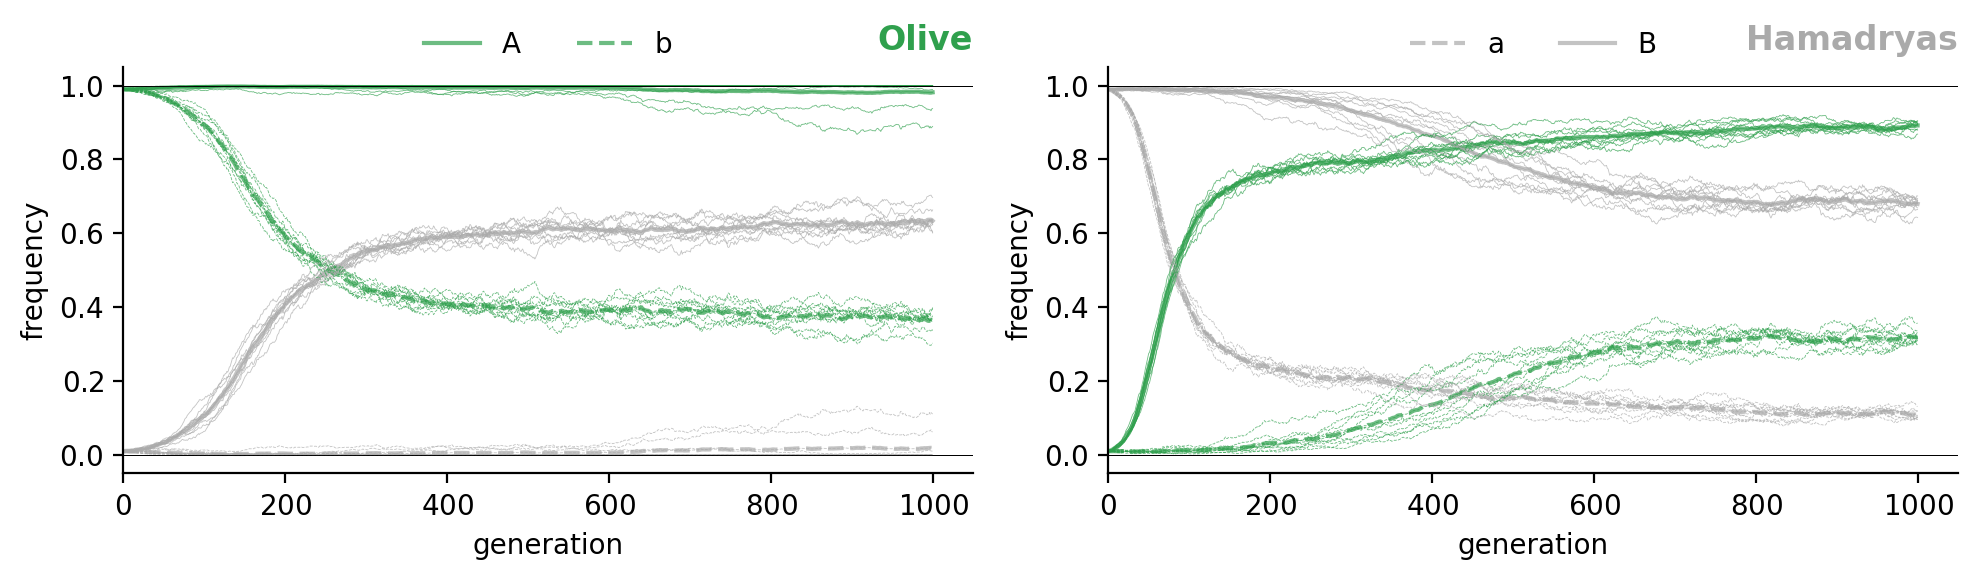

In [14]:
sim(Ab_bdmi_s=-0.12, aB_bdmi_s=-0.08, AB_bdmi_s=-0.07, ab_bdmi_s=-0.04)

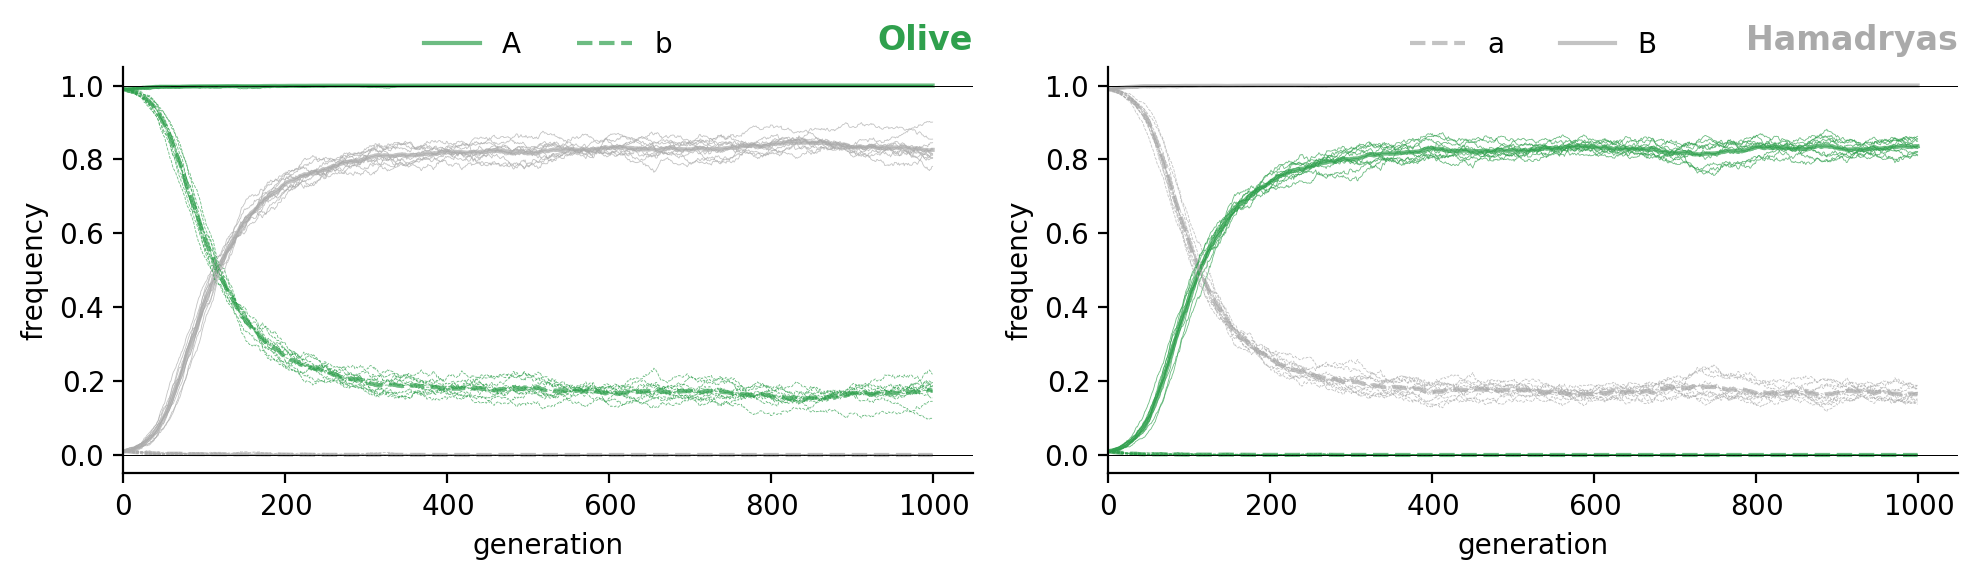

In [15]:
sim(Ab_bdmi_s=-0.08, aB_bdmi_s=-0.08, AB_bdmi_s=-0.04, ab_bdmi_s=-0.06)

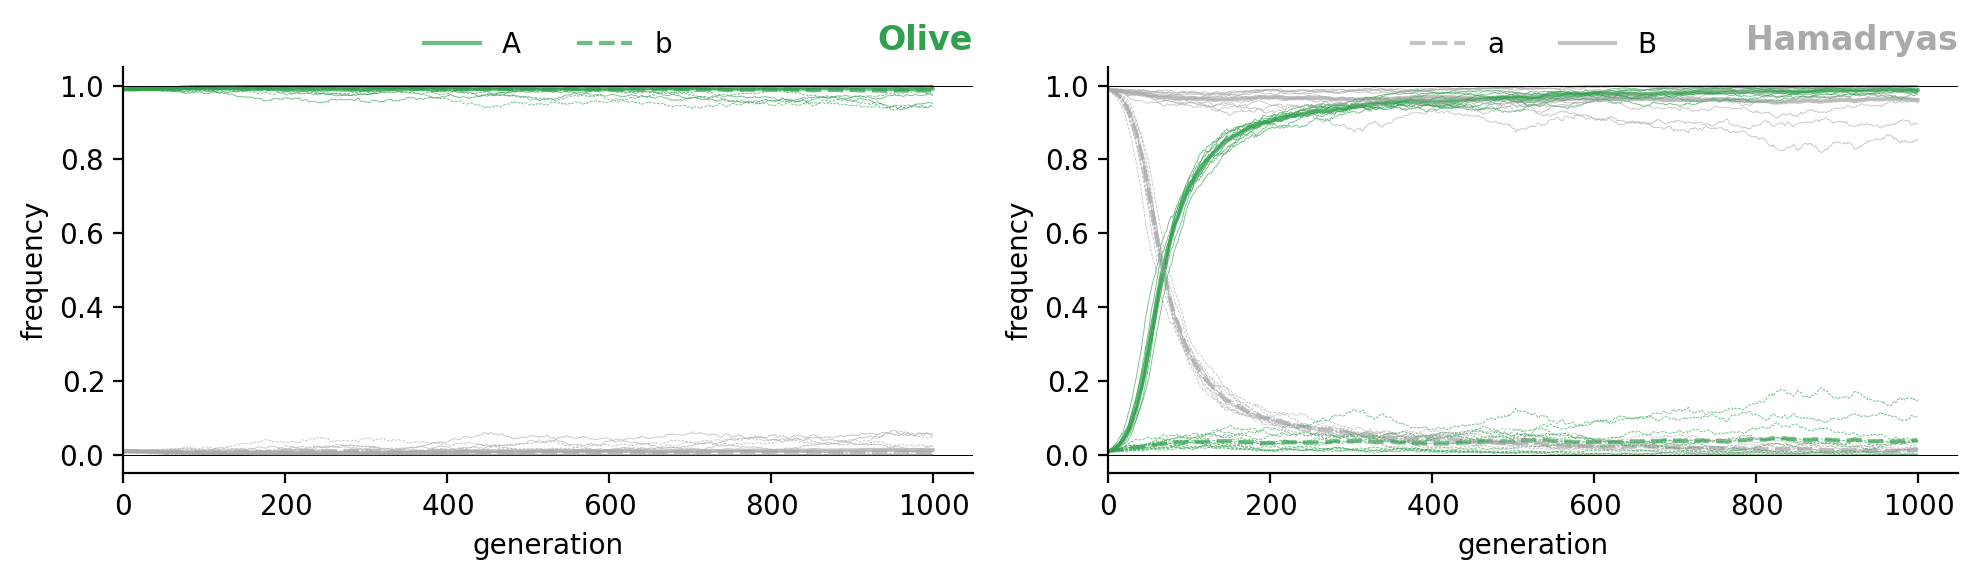

In [16]:
sim(Ab_bdmi_s=-0.08, aB_bdmi_s=-0.0, AB_bdmi_s=-0.0, ab_bdmi_s=-0.0)

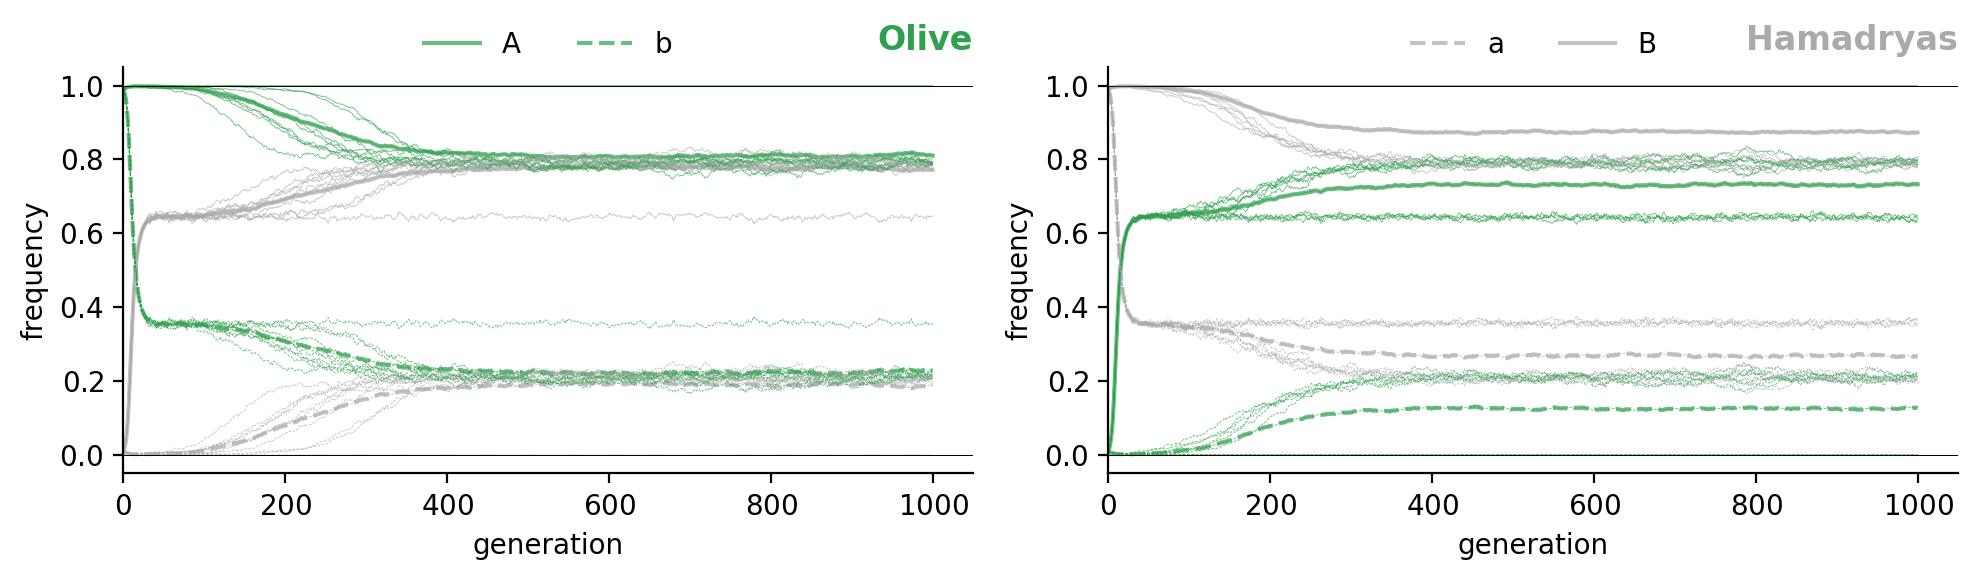

In [17]:
sim(Ab_bdmi_s=-0.6, aB_bdmi_s=-0.6, AB_bdmi_s=-0.5, ab_bdmi_s=-0.5)

# Baboon scenarios

---

## BDMI on both AB and ab combinations and 1% constant migration

## Negative selection: -0.5

---

In [18]:
# #| echo: true
# plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=bfr, B2_freq=bfr, 
#               AB_bdmi_s=-0.5, ab_bdmi_s=-0.25)

In [19]:
# #| echo: true
# plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=0, B2_freq=0, 
#               AB_bdmi_s=-0.5, ab_bdmi_s=-0.25)

In [20]:
params = dict(
    generations=1000, 
    N1=30000, 
    N2=30000, 
    M1=0, 
    M2=300, 
    init_pulse1=0, 
    init_pulse2=0,
    AB_bdmi_dom=0.5, 
    A_dom=0.5, 
    B_dom=0.5, 
    A2_freq=0, 
    B2_freq=0, 
    A2_s=0, 
    B2_s=0, 
    A_s=0, 
    B_s=0, 
    a_s=0, 
    b_s=0, 
    AB_bdmi_s=-0.5, 
    ab_bdmi_s=-0.25,
)
plot_simulation(params, **kwargs)

NameError: name 'kwargs' is not defined

---

Here fixing introgression requires an initial pulse swapping MPA in population 2:

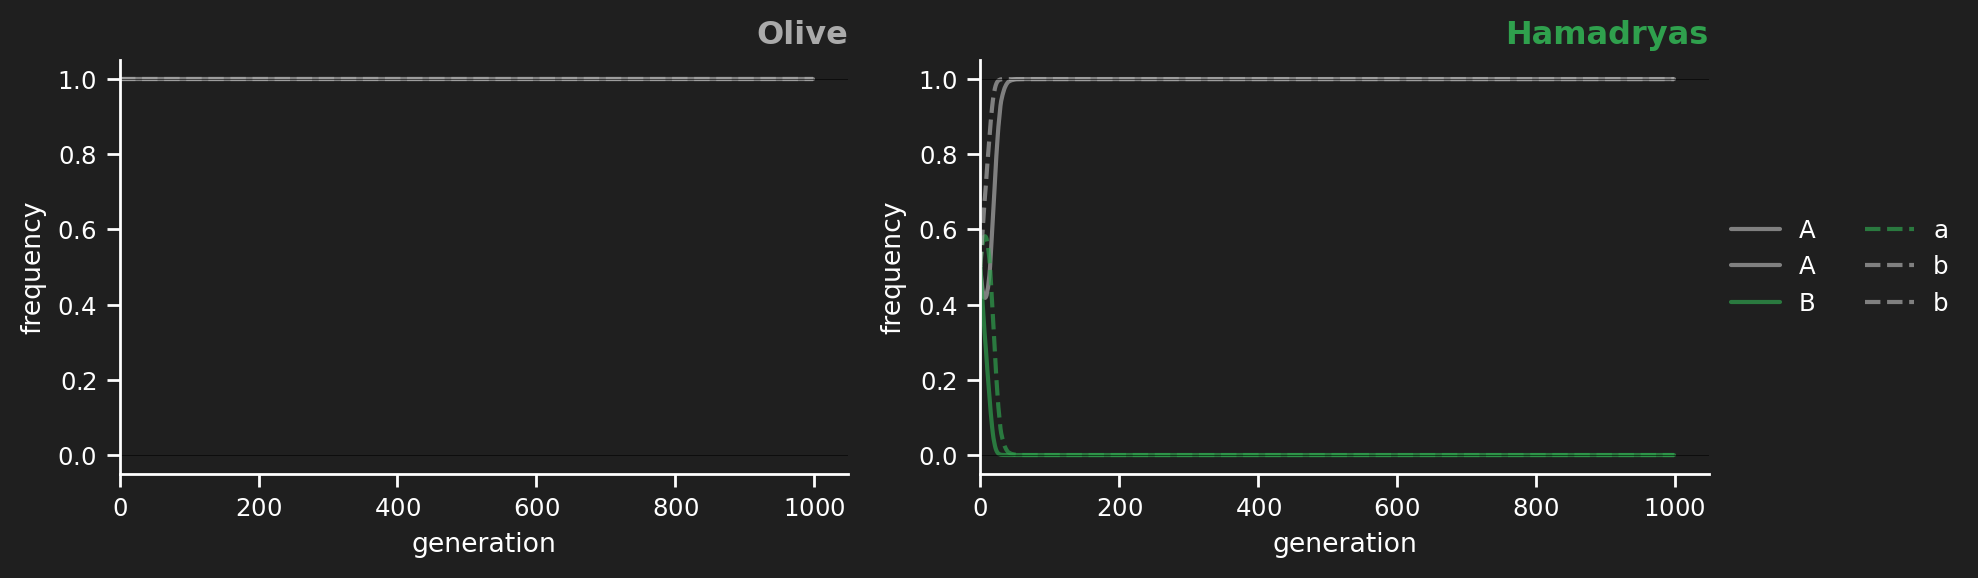

In [ ]:
params['init_pulse2'] = 0.5
plot_simulation(params, **kwargs)

---

## Negative selection: -0.15

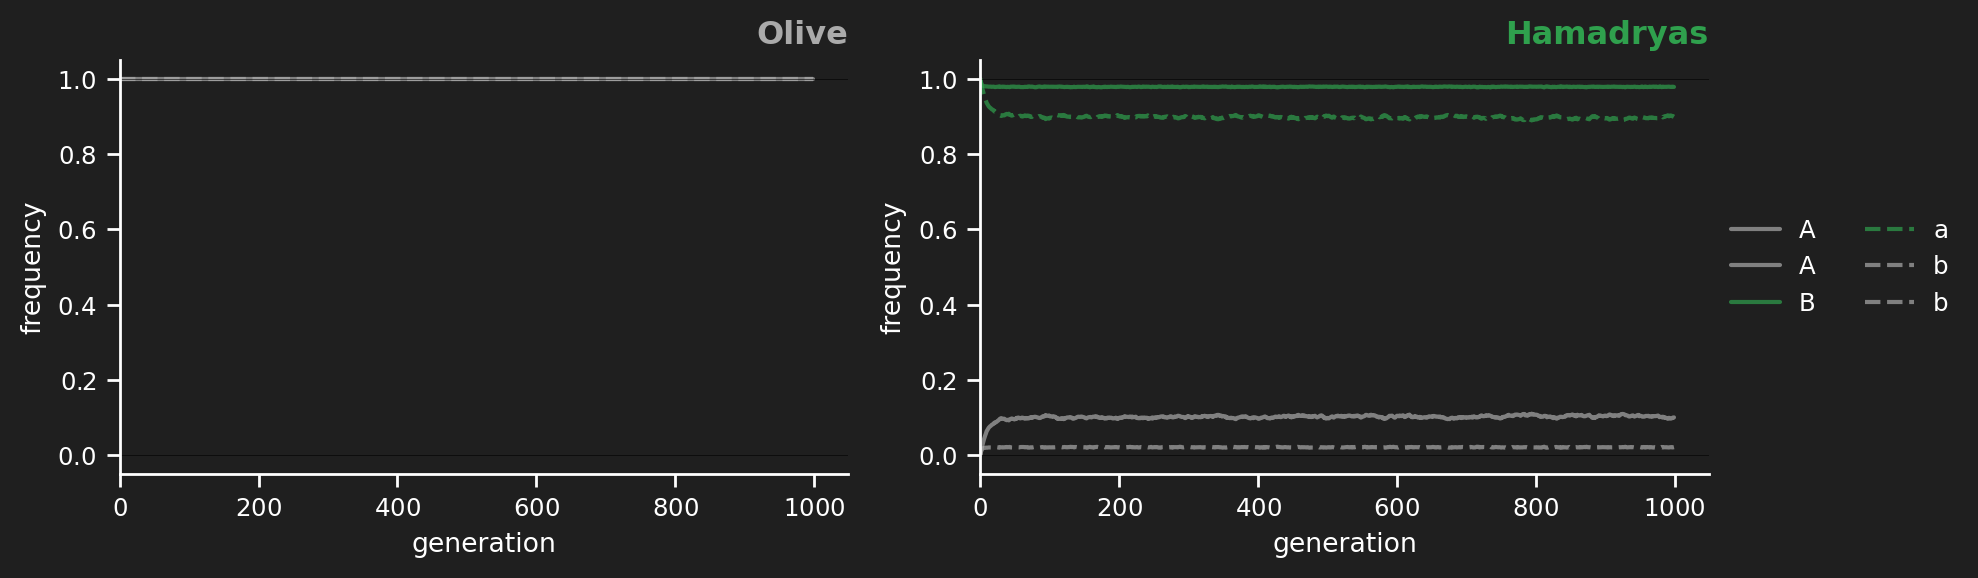

In [ ]:
params['init_pulse2'] = 0
params['AB_bdmi_s'] = -0.15
params['ab_bdmi_s'] = -0.7
plot_simulation(params, **kwargs)

---

Here fixing introgression only requires an initial pulse reducing MPA to 0.6. The migration-selection equilibrium already shifts it about 10% (above)

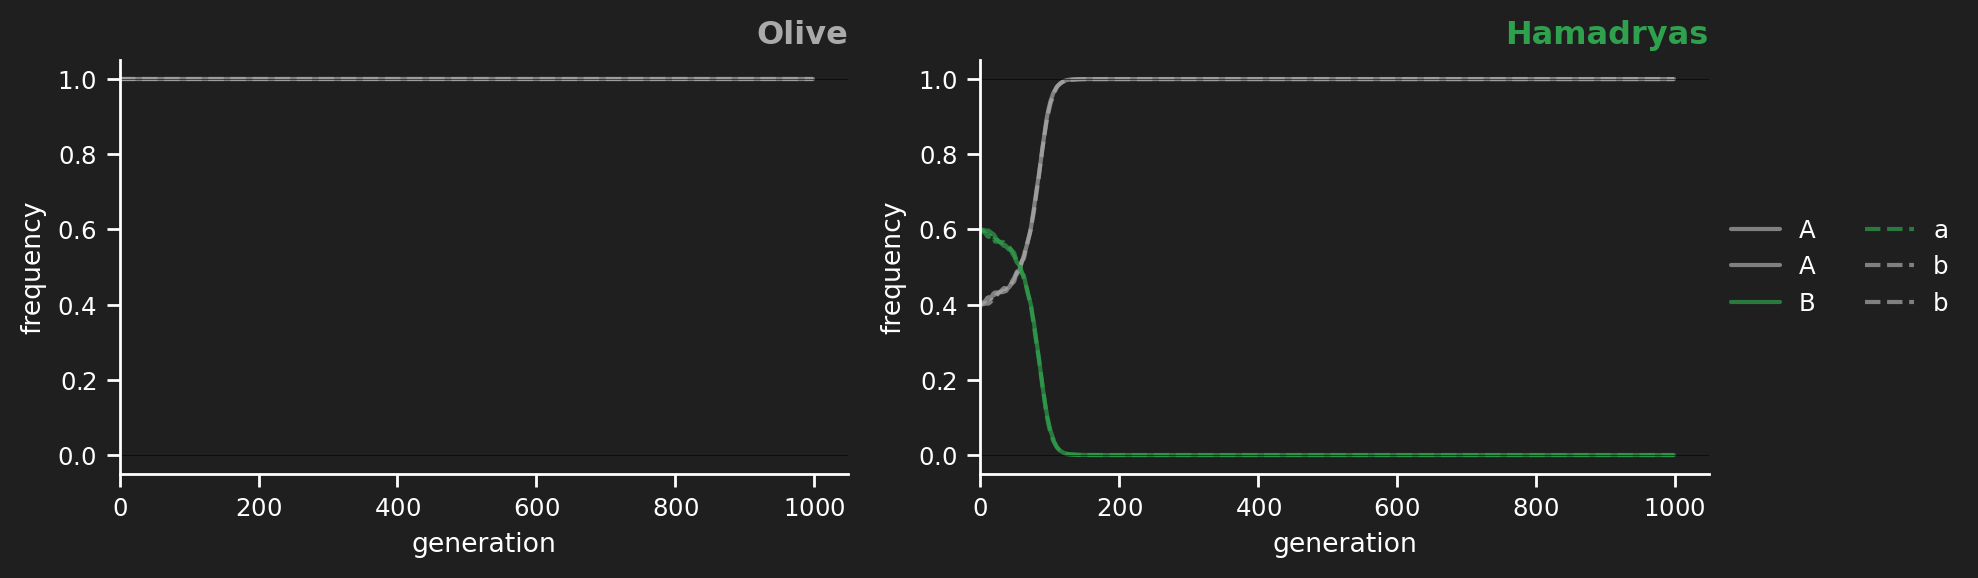

In [ ]:
params['init_pulse2'] = 0.4
params['AB_bdmi_s'] = -0.15
params['ab_bdmi_s'] = -0.15
plot_simulation(params, **kwargs)

---

## No selection

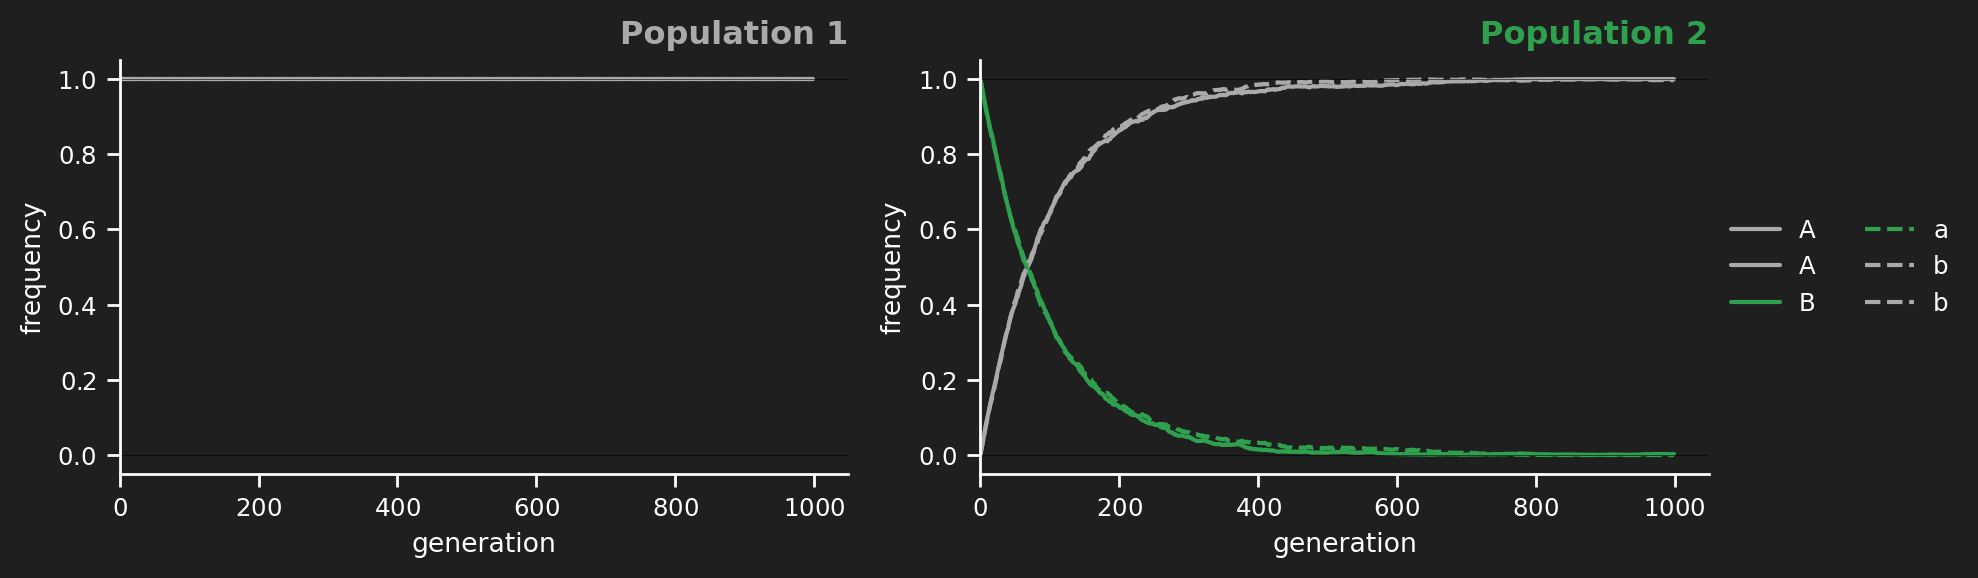

In [ ]:
#| echo: true
plot(simulate(
    generations=1000,
    N1=30000, N2=30000, 
    M1=0, M2=300,  
    init_pulse1=0, init_pulse2=0,
    A2_freq=0, B2_freq=0, 
    AB_bdmi_s=-0.0, ab_bdmi_s=-0.0,
    A_s=0, B_s=0,
    A2_s=0, B2_s=0, 
    a_s=0, b_s=0, 
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

## Negative selection: -0.1

In [ ]:
# #| echo: true
# plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=0, B2_freq=0, 
#               AB_bdmi_s=-0.1, ab_bdmi_s=-0.1)

In [ ]:
# #| echo: true
# plot_scenario(samples, generations=3000, N1=30000, N2=30000, M1=0, M2=30, A2_freq=bfr, B2_freq=bfr, 
#               AB_bdmi_s=s, ab_bdmi_s=s)

---

Here an initial pulse just only slighly accelerates fixation of A and b in population 2:

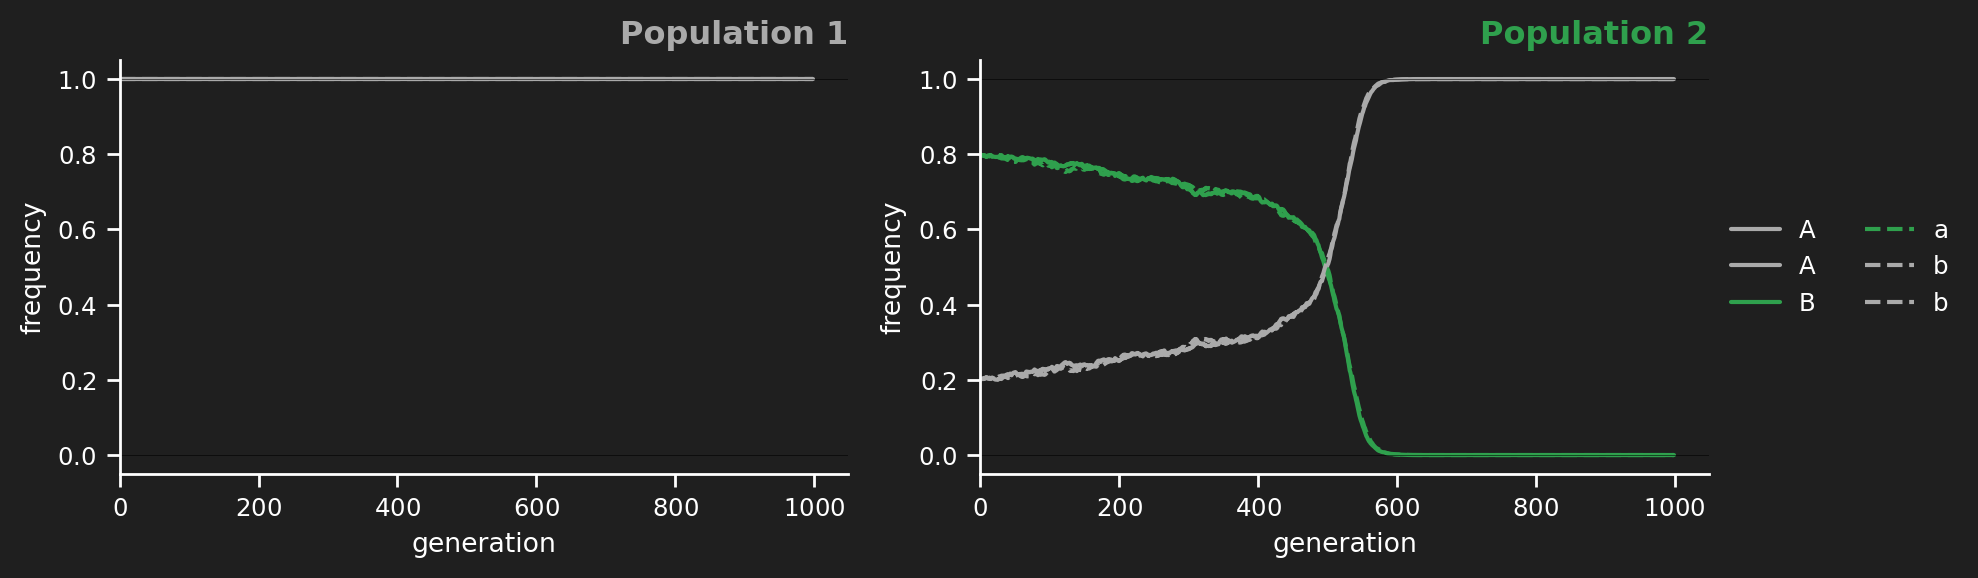

In [ ]:
plot(simulate(
    generations=1000,
    N1=30000, N2=30000, 
    M1=0, M2=300,  
    init_pulse1=0, init_pulse2=0.2,
    A2_freq=0, B2_freq=0, 
    AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
    A_s=0, B_s=0,
    A2_s=0, B2_s=0, 
    a_s=0, b_s=0, 
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Stable high admixture proportions

Increasing selection to 0.11 prevents A from fixing:

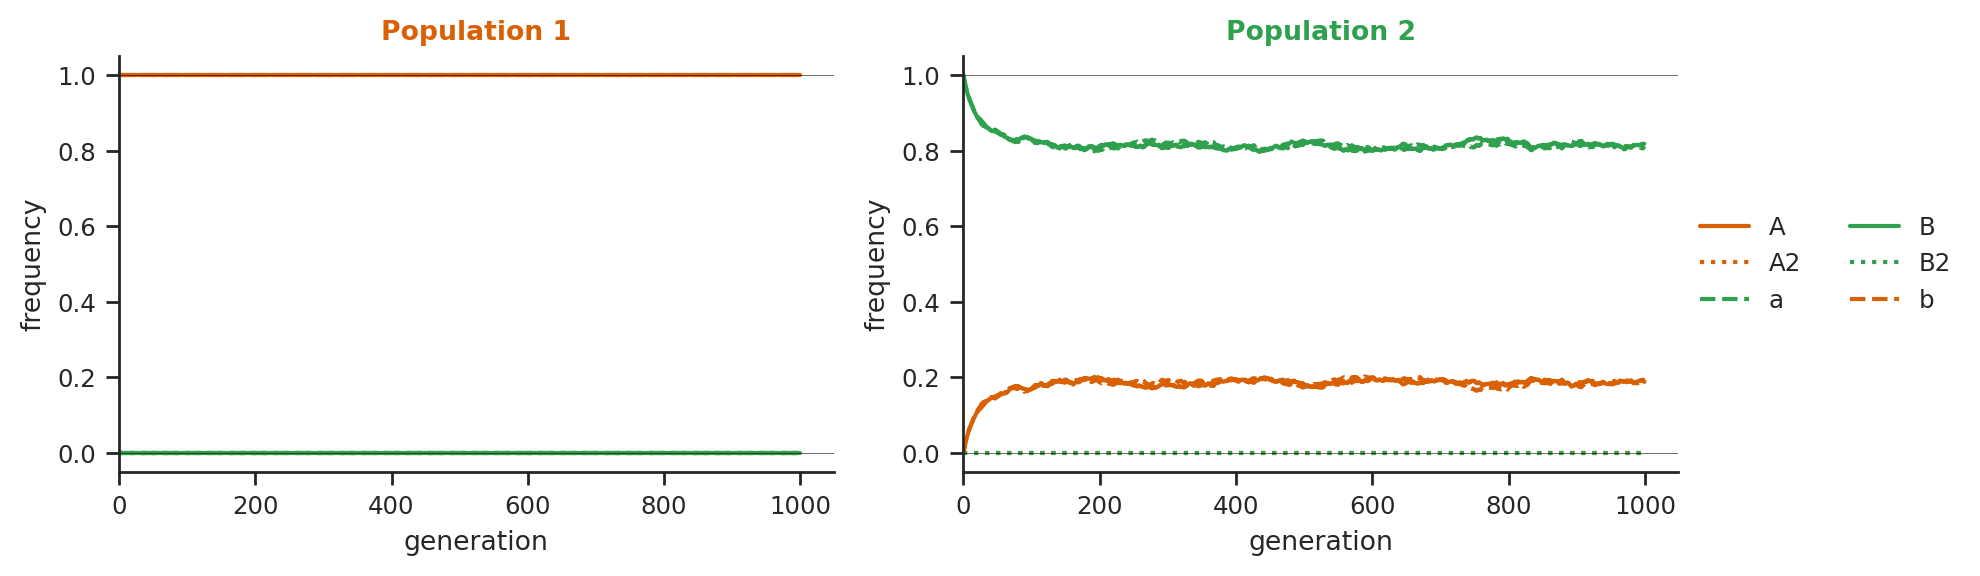

In [ ]:
plot(simulate(
    generations=1000,
    N1=30000, N2=30000, 
    M1=0, M2=300,  
    init_pulse1=0, init_pulse2=0,
    A2_freq=0, B2_freq=0, 
    AB_bdmi_s=-0.11, ab_bdmi_s=-0.11,
    A_s=0, B_s=0,
    A2_s=0, B2_s=0, 
    a_s=0, b_s=0, 
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

Lowering migration rate below 1% produce same result:

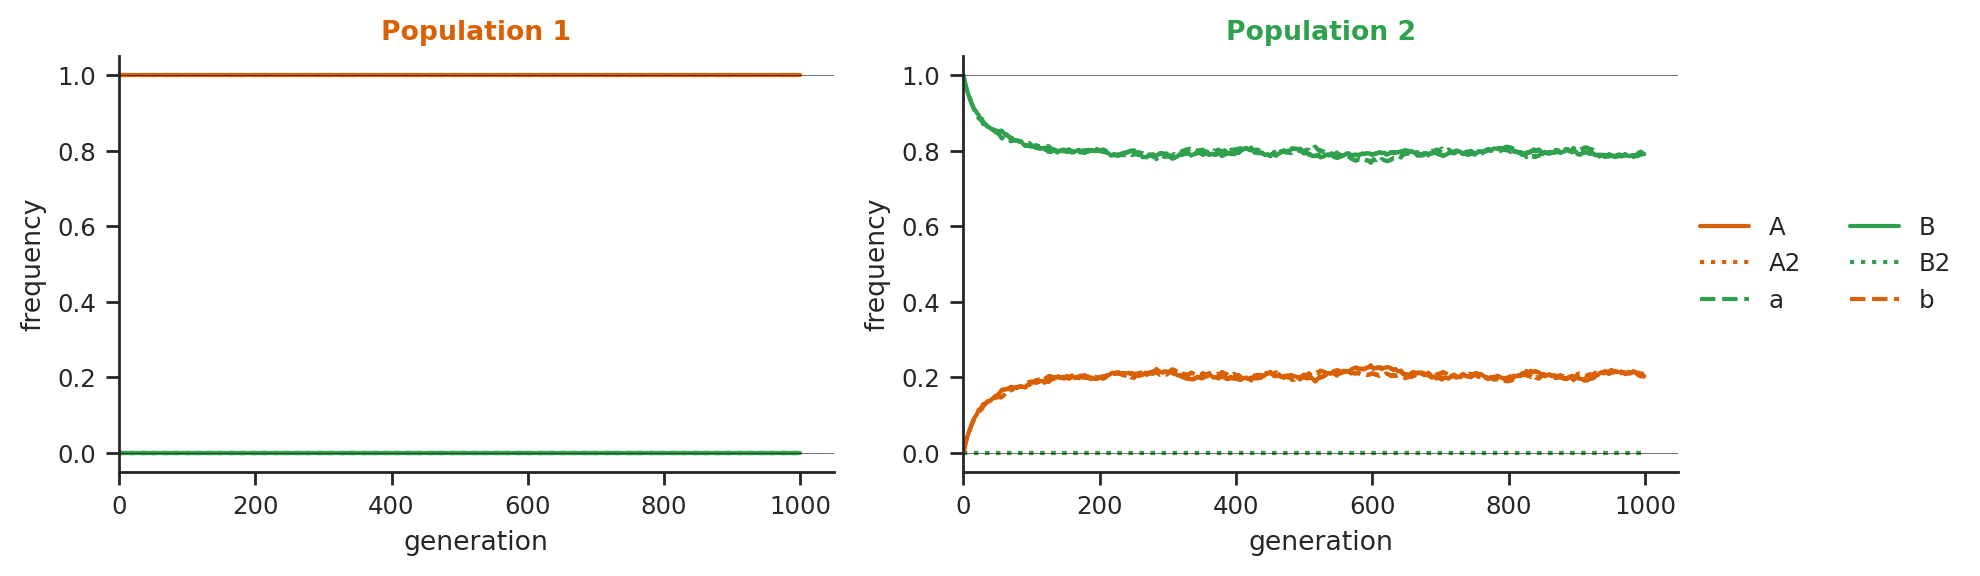

In [ ]:
plot(simulate(
    generations=1000,
    N1=30000, N2=30000, 
    M1=0, M2=280,  
    init_pulse1=0, init_pulse2=0,
    A2_freq=0, B2_freq=0, 
    AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
    A_s=0, B_s=0,
    A2_s=0, B2_s=0, 
    a_s=0, b_s=0, 
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

So does adding 1/3 % migration in the other direction (reduces effective migration rate into population 2):

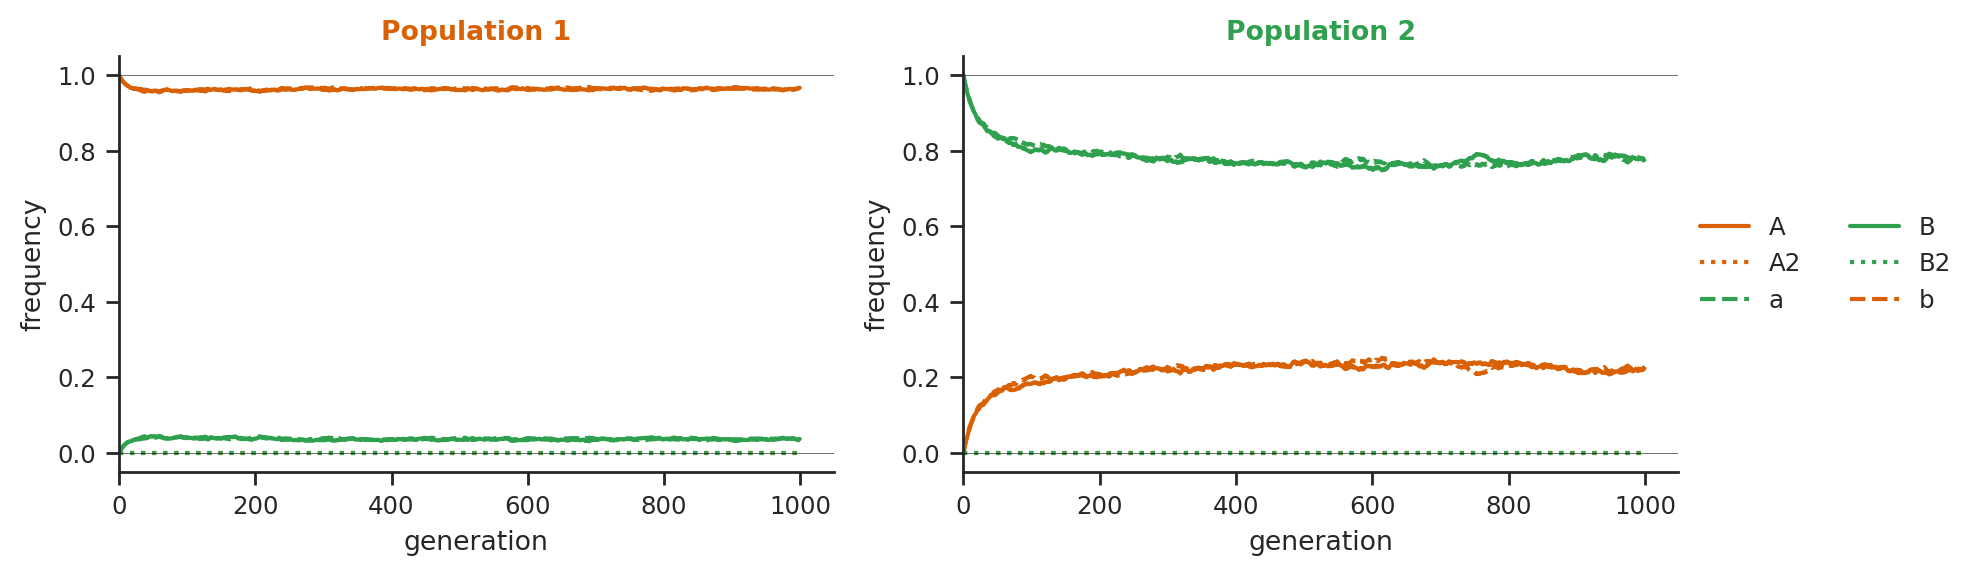

In [ ]:
plot(simulate(
    generations=1000,
    N1=30000, N2=30000, 
    M1=100, M2=300,  
    init_pulse1=0, init_pulse2=0,
    A2_freq=0, B2_freq=0, 
    AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
    A_s=0, B_s=0,
    A2_s=0, B2_s=0, 
    a_s=0, b_s=0, 
    AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Conclusion

In this model with **1% unidirectional migration** and selection on **both AB and ab incompatibility**, selection coeficients **above/below 10%** determine major paraent ancestry in population 2.

---

# Combined drive and hybrid incompatibility

## Lower negative bdmi seelection on ab:

If selection on ab genotypes is lowered, b alleles from population 1 will displace a and B in population 2, allowing A to fix.

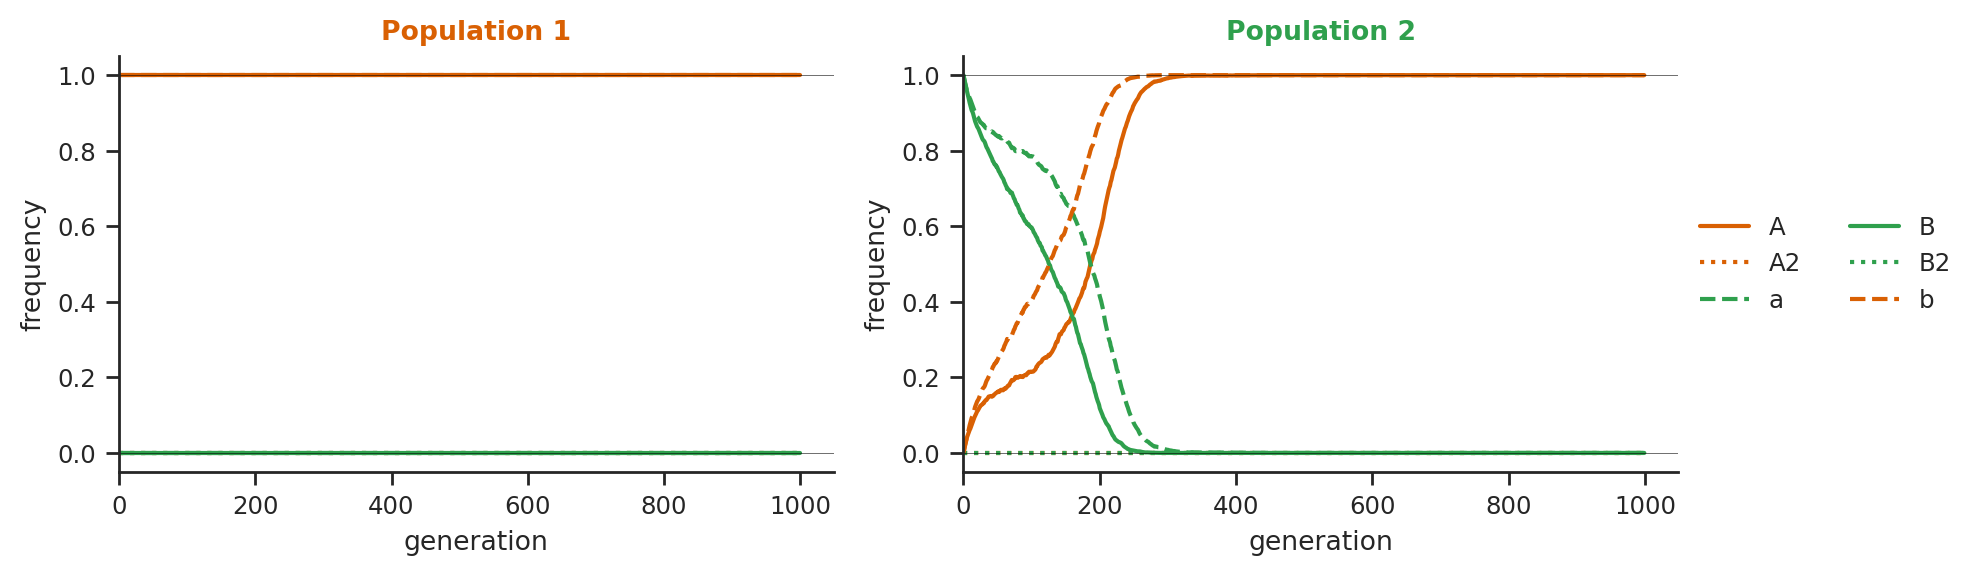

In [ ]:
plot(
    simulate(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=280,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.05,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

## Funky scenarios...

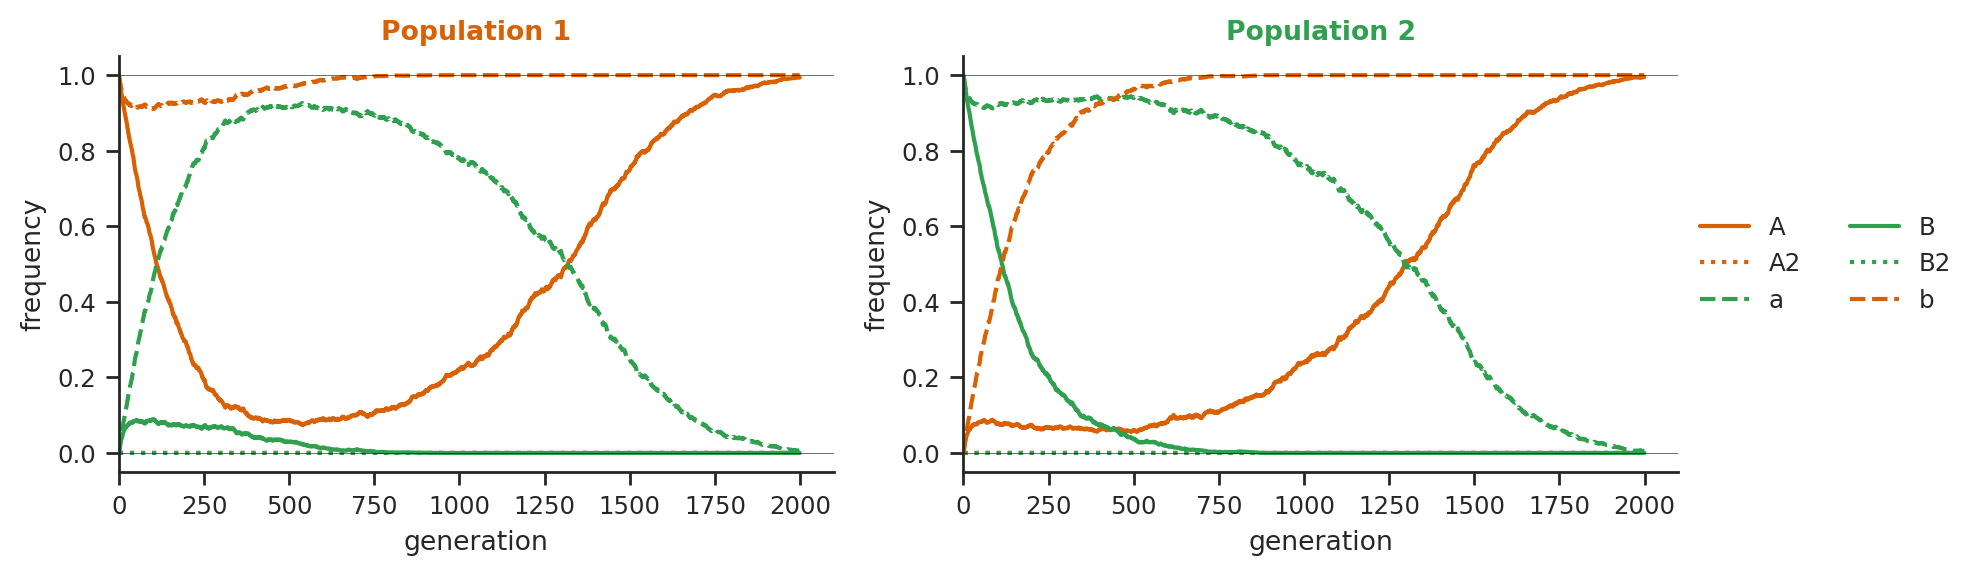

In [ ]:
plot(
    simulate(generations=2000,
                                              N1=30000, N2=30000, 
                                              M1=200, M2=200,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.01,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

# Correlation of ancestry in two populations

In [ ]:


def plot_scenario(samples, plot_all=False, **kwargs):
    
    
    # interations, generations, populations, alleles (A, A2, a, B, B2, b):
    # fun = partial(compute_twolocus_twoallele_sample_data, **kwargs)
    # tensor = np.stack([fun(iteration=1) for _ in range(samples)])  
    kwargs['iteration'] = 1
    fun = partial(simulate, **kwargs)
    try:
        import multiprocess
        tensor = np.stack(POOL.map(fun, range(samples)))
    except:
        tensor = np.stack(map(fun, range(samples)))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=stats.ConstantInputWarning)
        generations = list(range(tensor.shape[1]))
        
        print([stats.spearmanr(tensor[:, g, 0, 0], tensor[:, g, 1, 0]).statistic for g in generations])


        A_spearman = [stats.spearmanr(tensor[:, g, 0, 0], tensor[:, g, 1, 0]).statistic for g in generations]
        B_spearman = [stats.spearmanr(tensor[:, g, 0, 3], tensor[:, g, 1, 3]).statistic for g in generations]

        A_pearson = [stats.pearsonr(tensor[:, g, 0, 0], tensor[:, g, 1, 0]).statistic for g in generations]
        B_pearson = [stats.pearsonr(tensor[:, g, 0, 3], tensor[:, g, 1, 3]).statistic for g in generations]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, height_ratios=[2,2])

    color1 = '#D96003'
    color2 = '#2FA04D'
    
    tensor_means = np.mean(tensor, axis=0)
    plot(tensor_means, #color1=color1, color2=color2, #pop1='Olive', pop2='Hamadryas',
                    linewidth=2, axes=axes[0, :], xlabel=None) ;

    if plot_all:
        for i in range(tensor.shape[0]):
            plot(tensor[i,:,:,:], #color1=color1, color2=color2, #pop1='Olive', pop2='Hamadryas',
                            linewidth=0.1, axes=axes[0, :], xlabel=None, alpha=1/np.log2(samples))


    if 'startmix' in kwargs:
        axes[0, 0].axhline(y=1-kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 0].axhline(y=kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 1].axhline(y=1-kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 1].axhline(y=kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')

    axes[1, 0].plot(generations, A_spearman, label='spearman', linewidth=2, color=color1)
    axes[1, 0].plot(generations, B_spearman, label='spearman', linewidth=2, color=color2)
    axes[1, 0].set_ylabel('coeficient')    
    axes[1, 0].set_ylim(-1, 1)    
    axes[1, 0].set_xlabel('generation')    
    axes[1, 0].set_title("Spearman cor of derived freq in pop1 and pop2" , fontweight='bold')
    axes[1, 0].axhline(y=0, linewidth=0.2, color='black')

    axes[1, 1].plot(generations, A_pearson, label='pearson', linewidth=2, color=color1)
    axes[1, 1].plot(generations, B_pearson, label='pearson', linewidth=2, color=color2)
    axes[1, 1].set_ylabel('coeficient')    
    axes[1, 1].set_ylim(-1, 1)    
    axes[1, 1].set_xlabel('generation')    
    axes[1, 1].set_title("Pearson cor of derived freq in pop1 and pop2" , fontweight='bold')
    axes[1, 1].axhline(y=0, linewidth=0.2, color='black')

#    axes[1, 0].set_ylabel('spearman')
    # axes[1, 1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

---

# Reproducing Schumer 2018 plot

---

## Schumer et al. 2028 Fig. S6

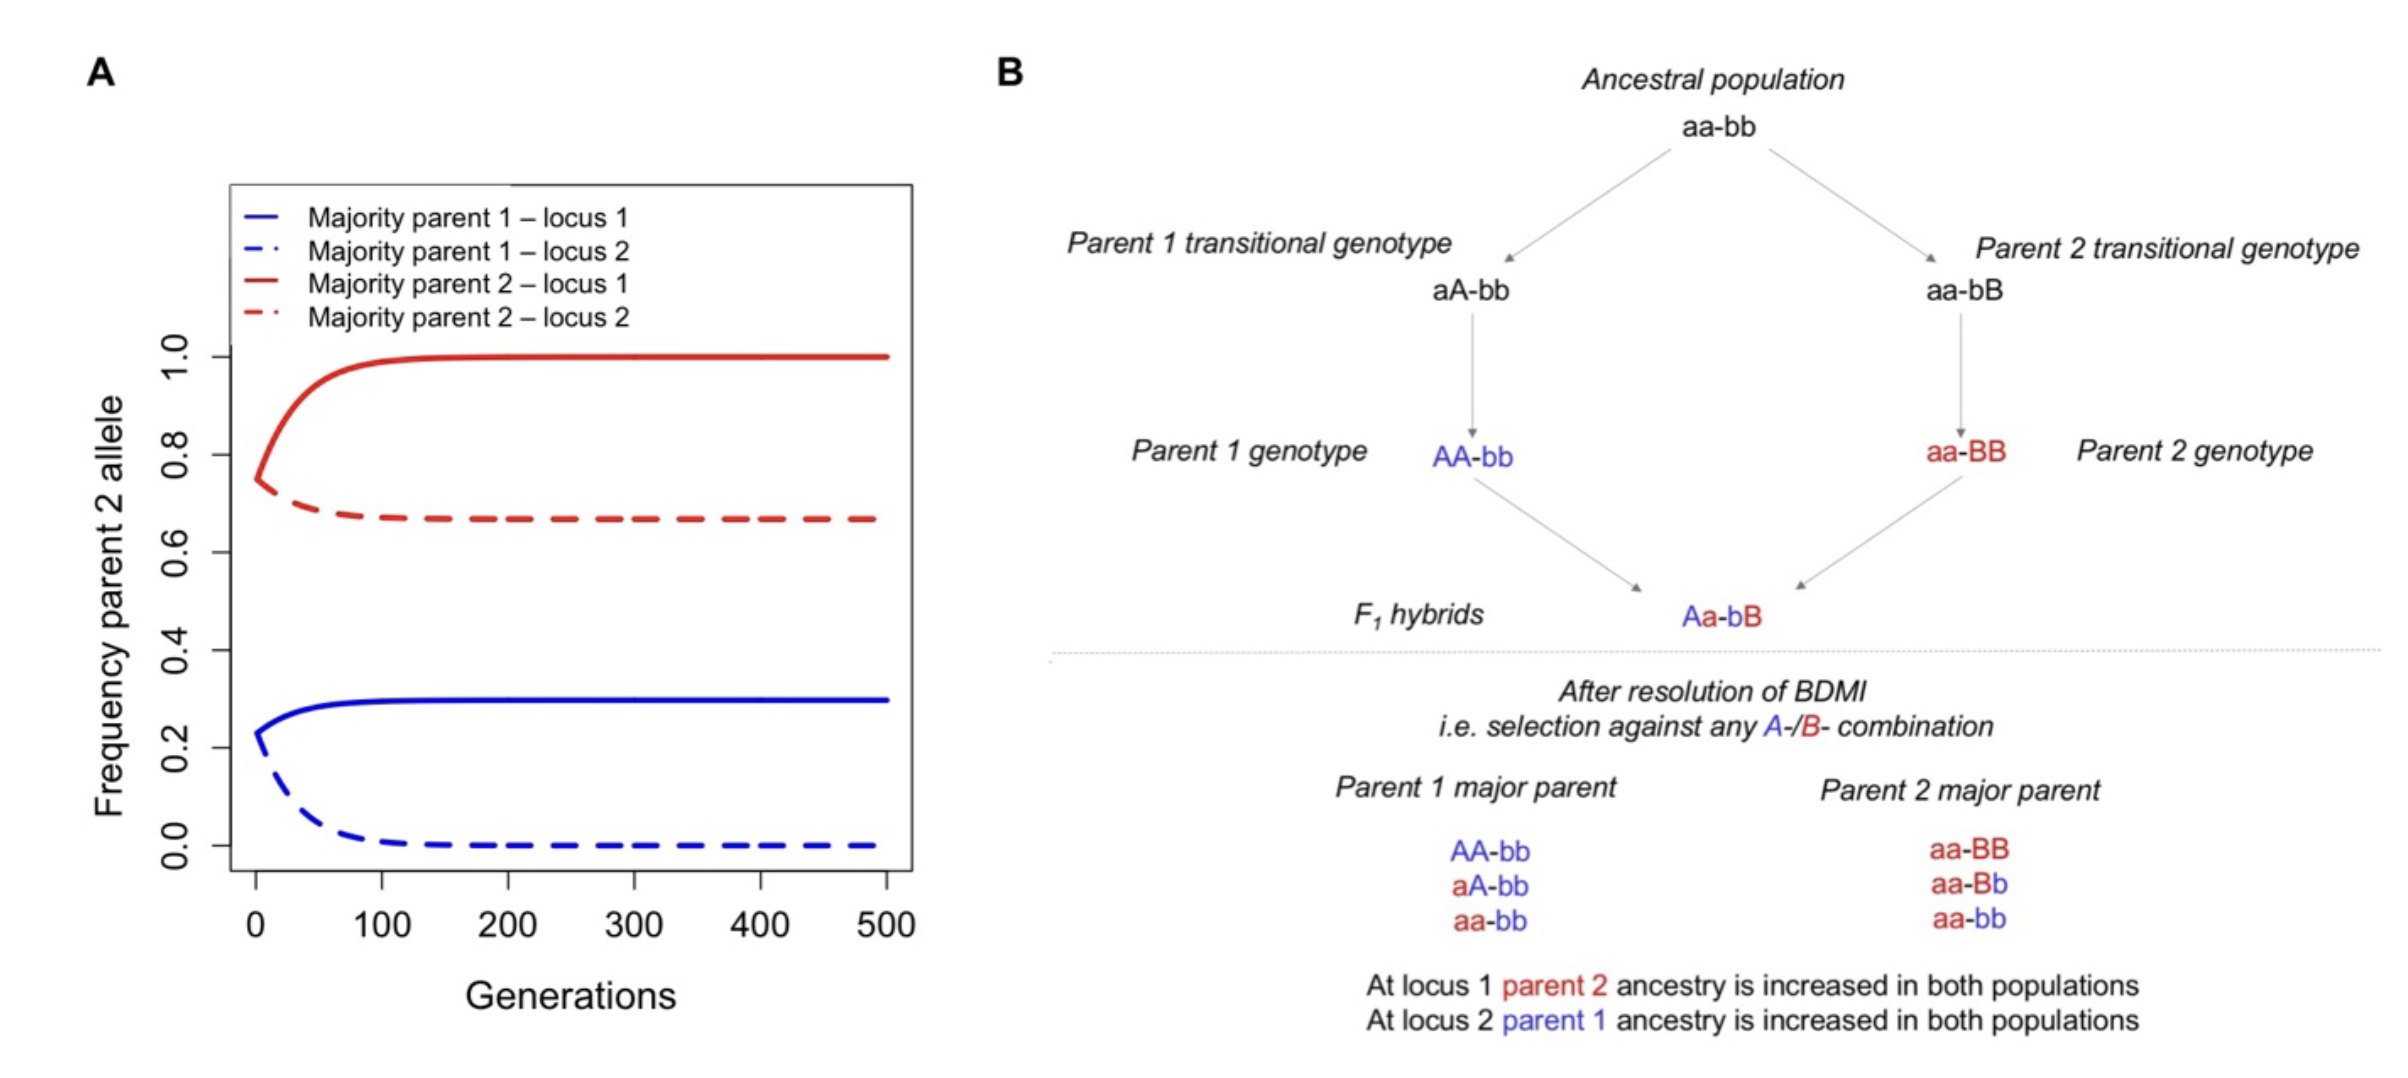

The b alleles, not incompatible with anything, somewhat displace the A alleles while the incompatible B alleles segregate.

---

## Shumer supplementary 

- Instant mixing (`startmix`) of populations with no subsequent migration
- It is assumed that there is no positive selection on A and B. I.e. the BDMI has developed neutrally.
  

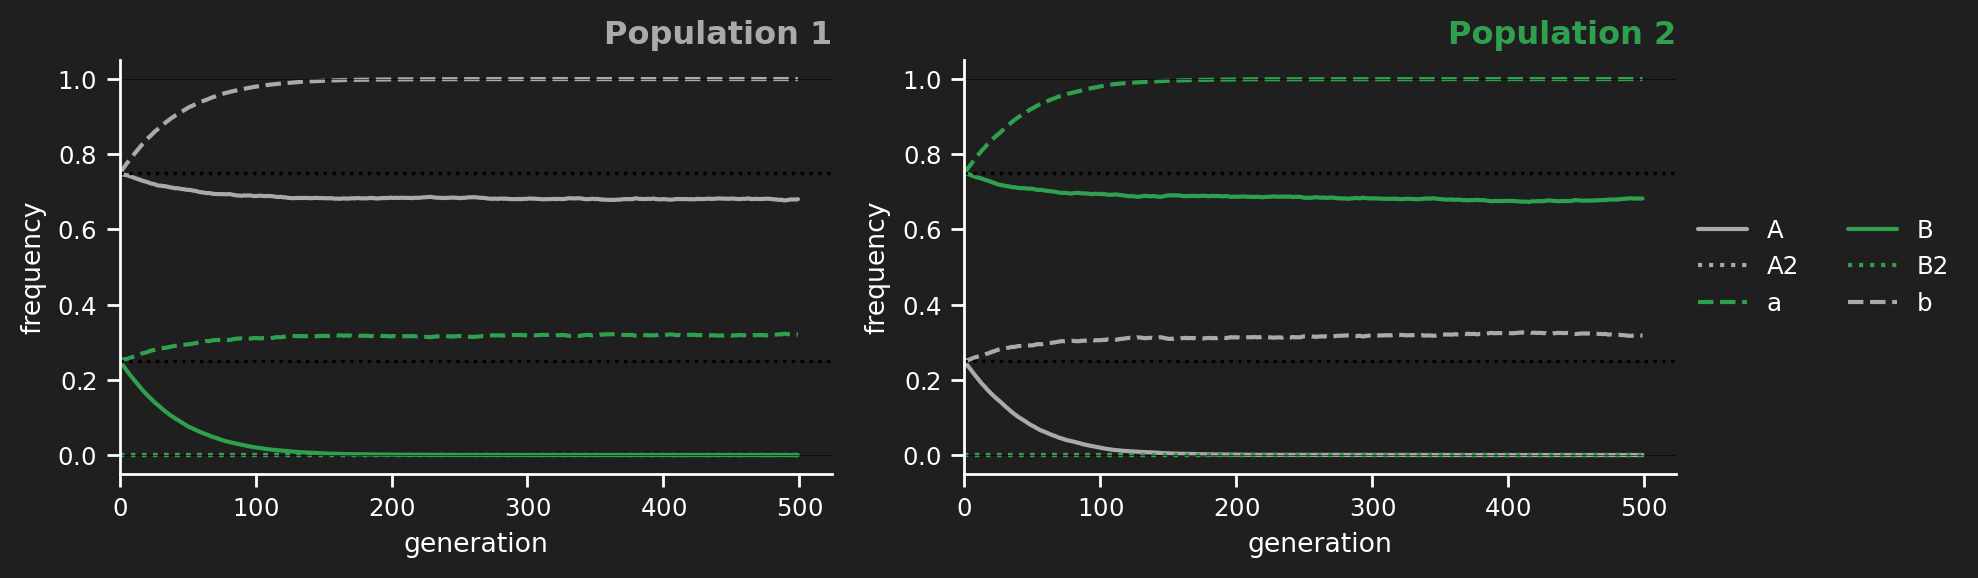

In [ ]:
startmix = 0.25
data = simulate(N1=500000, N2=500000, M1=0, M2=0, 
                                              generations=500, 
                                              startmix=startmix, 
                                              AB_bdmi_s=-0.05)
ax1, ax2 = plot(data) 
ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
ax1.axhline(y=startmix, linestyle='dotted', color='black')
ax2.axhline(y=1-startmix, linestyle='dotted', color='black')
ax2.axhline(y=startmix, linestyle='dotted', color='black') ;

---

# Between-population correlation of A and B frequency across many loci

In [90]:
#| echo: true
samples = 1000
s = -0.01

---

## All loci with same AB_bdmi_s

[nan, np.float64(0.03343021814959793), np.float64(0.07974923148300403), np.float64(0.02568955601982648), np.float64(-0.06105061390216629), np.float64(-0.06801040692245576), np.float64(-0.051363166722812534), np.float64(-0.026830243033025006), np.float64(-0.0440910917281586), np.float64(-0.03162108955747636), np.float64(-0.04109881847449745), np.float64(-0.06635304915130821), np.float64(-0.030669207894358116), np.float64(-0.03631179347505481), np.float64(-0.09190090536676808), np.float64(-0.0939339101786213), np.float64(-0.08241225680300843), np.float64(-0.07915012595950727), np.float64(-0.05097154950439783), np.float64(-0.043592838588644385), np.float64(0.008504529166950252), np.float64(-0.03084552505972428), np.float64(-0.05185249116606757), np.float64(-0.08414795506241524), np.float64(-0.11096365231476785), np.float64(-0.10105959040948287), np.float64(-0.0973347382140595), np.float64(-0.13090955955112604), np.float64(-0.15000326858037916), np.float64(-0.11184544149297), np.float64(-0

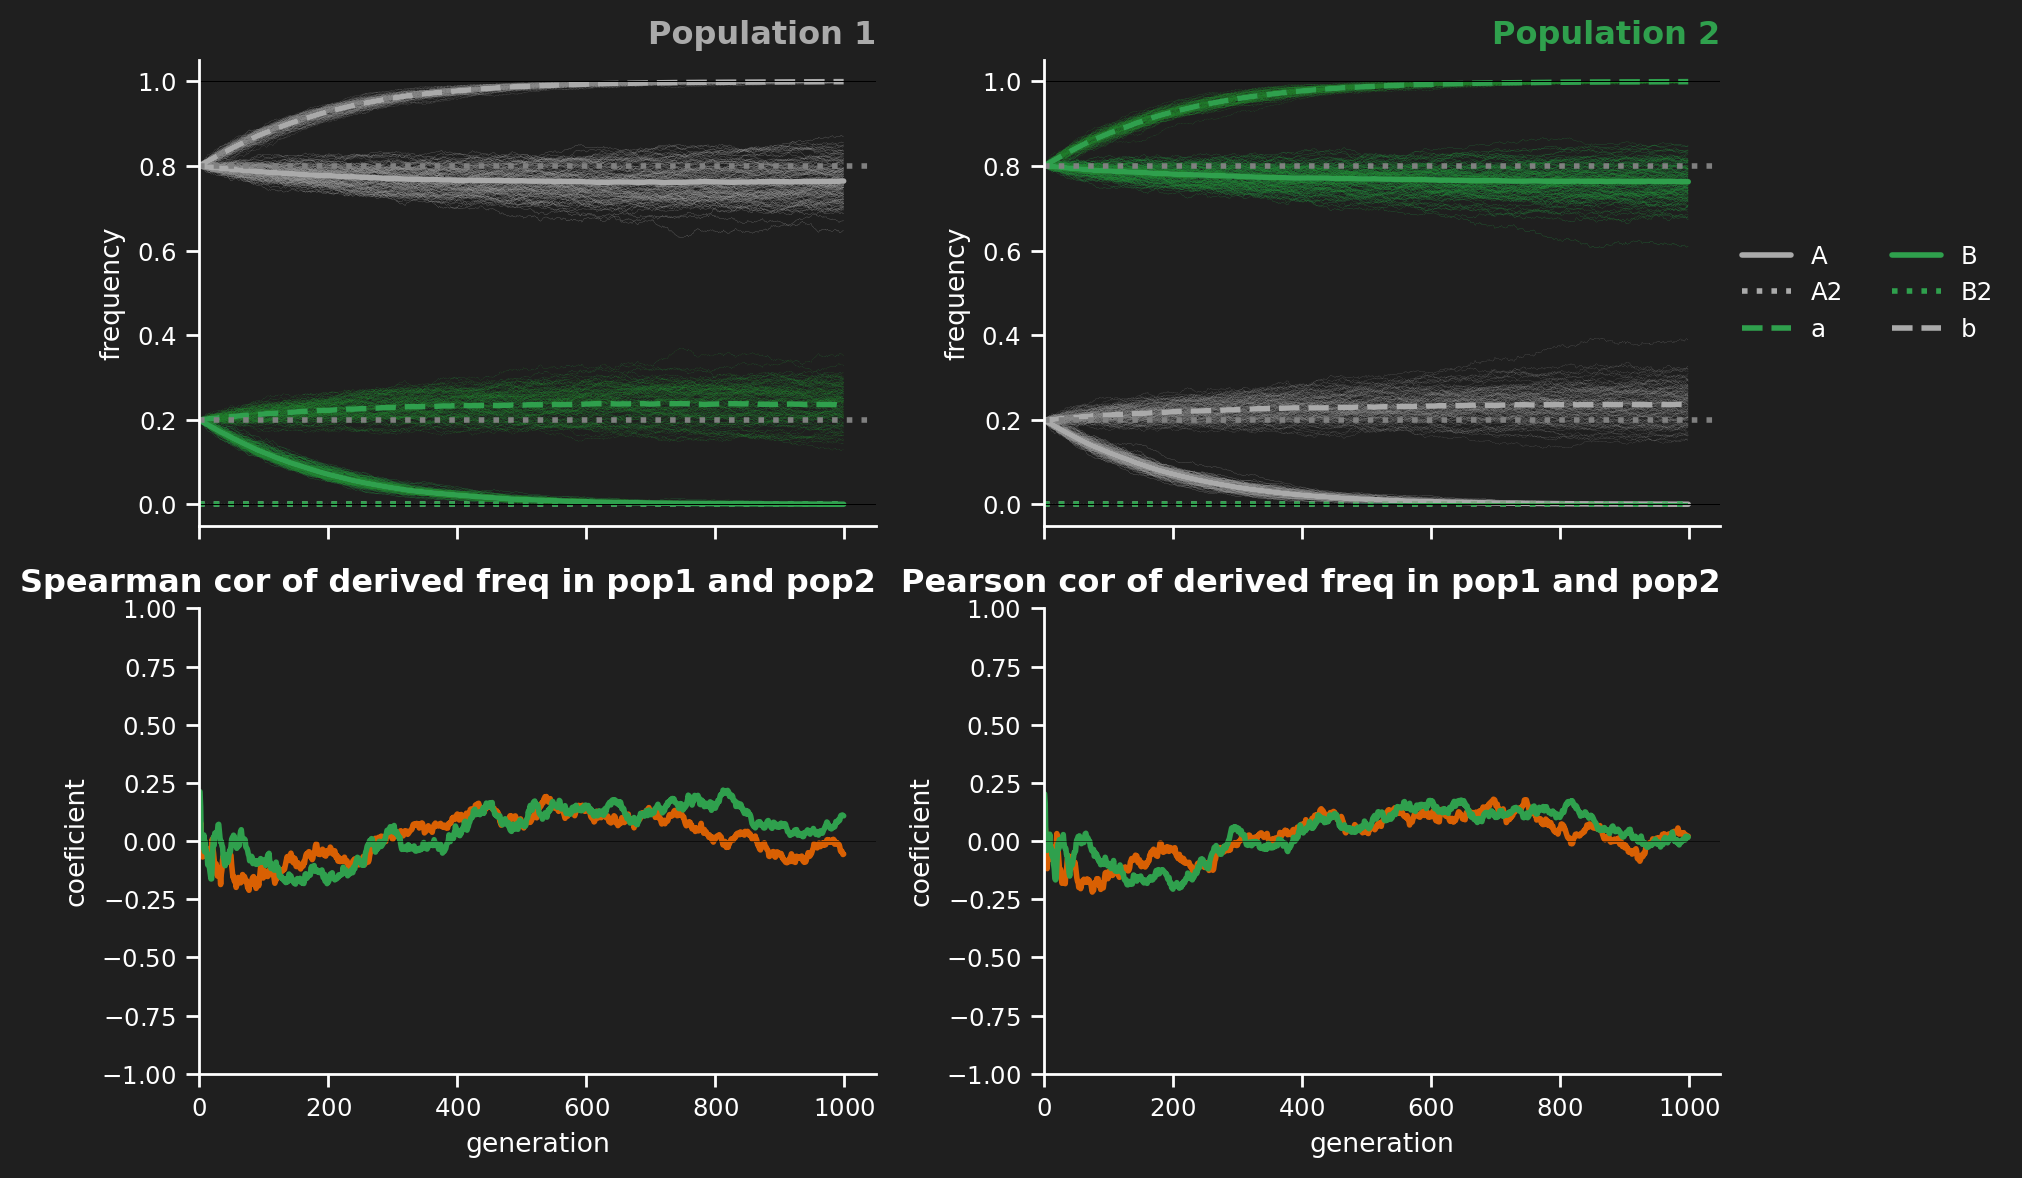

In [91]:
%%time
#| echo: true
plot_scenario(samples, plot_all=True, startmix=0.2, AB_bdmi_s=s)

---

## Gamma distributed s: `gam_s`

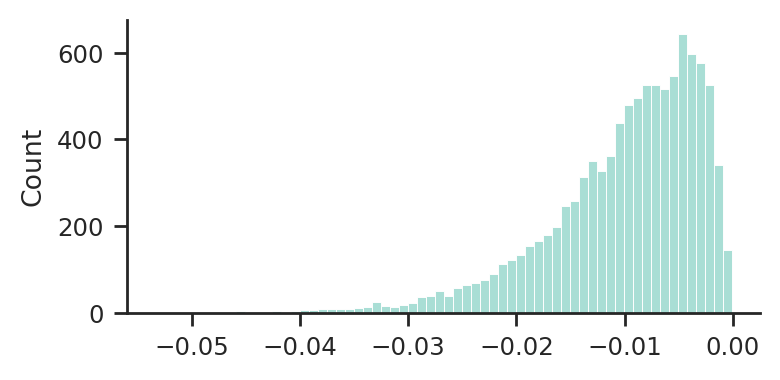

In [19]:
#| echo: false
#| label: fig-gamma
#| fig-cap: "Gamma distributed s"

def gam_s():
    s = 0.01
    return -gamma(2, np.abs(s) / 2, 1)[0]

sns.displot([gam_s() for _ in range(10000)], height=2, aspect=2) ;

In [20]:
#| echo: false
#| label: doc-gamma

Markdown(f"""
         
Allows s to be gamma distributed...

""")



Allows s to be gamma distributed...



---

## Interspersed non-zero s: `inter_s`

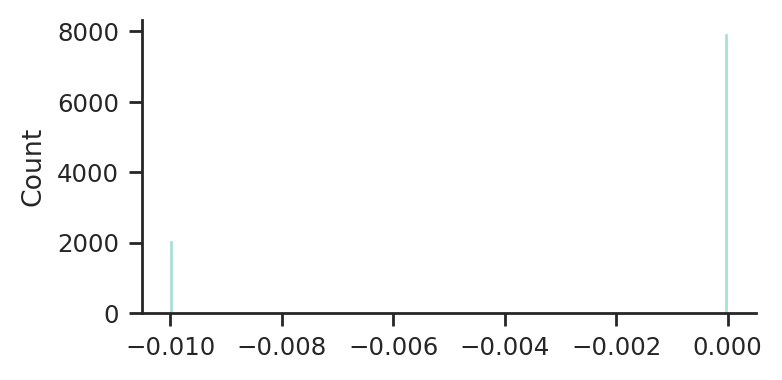

In [21]:
#| echo: false
#| label: fig-interspersed
#| fig-cap: "This is a figure caption"

def inter_s():
    s = -0.01
    return s * np.random.choice([0, 1], p=(0.8, 0.2))

sns.displot([inter_s() for _ in range(10000)], height=2, aspect=2) ;

---

## "Almost fixed" A and B

E.g. including only sites fixed in a large sample.

Hack: beta dist A2_freq and B2_freq:

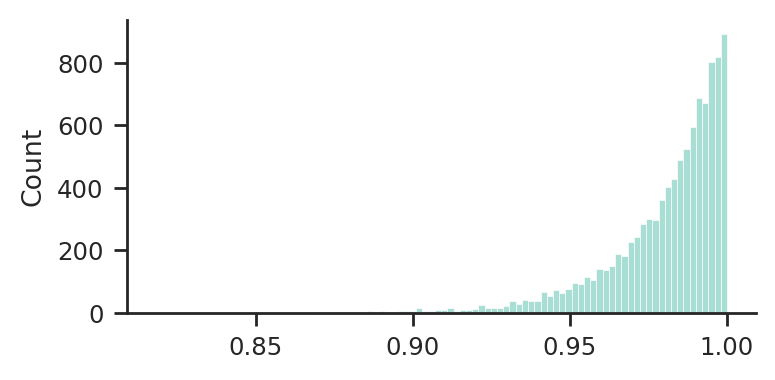

In [22]:
def bfr():
    return beta(1, 50)

sns.displot([1-bfr() for _ in range(10000)], height=2, aspect=2) ;

---

# Initial pulse only

---

## Adding gamma distributed s

### No BDMI

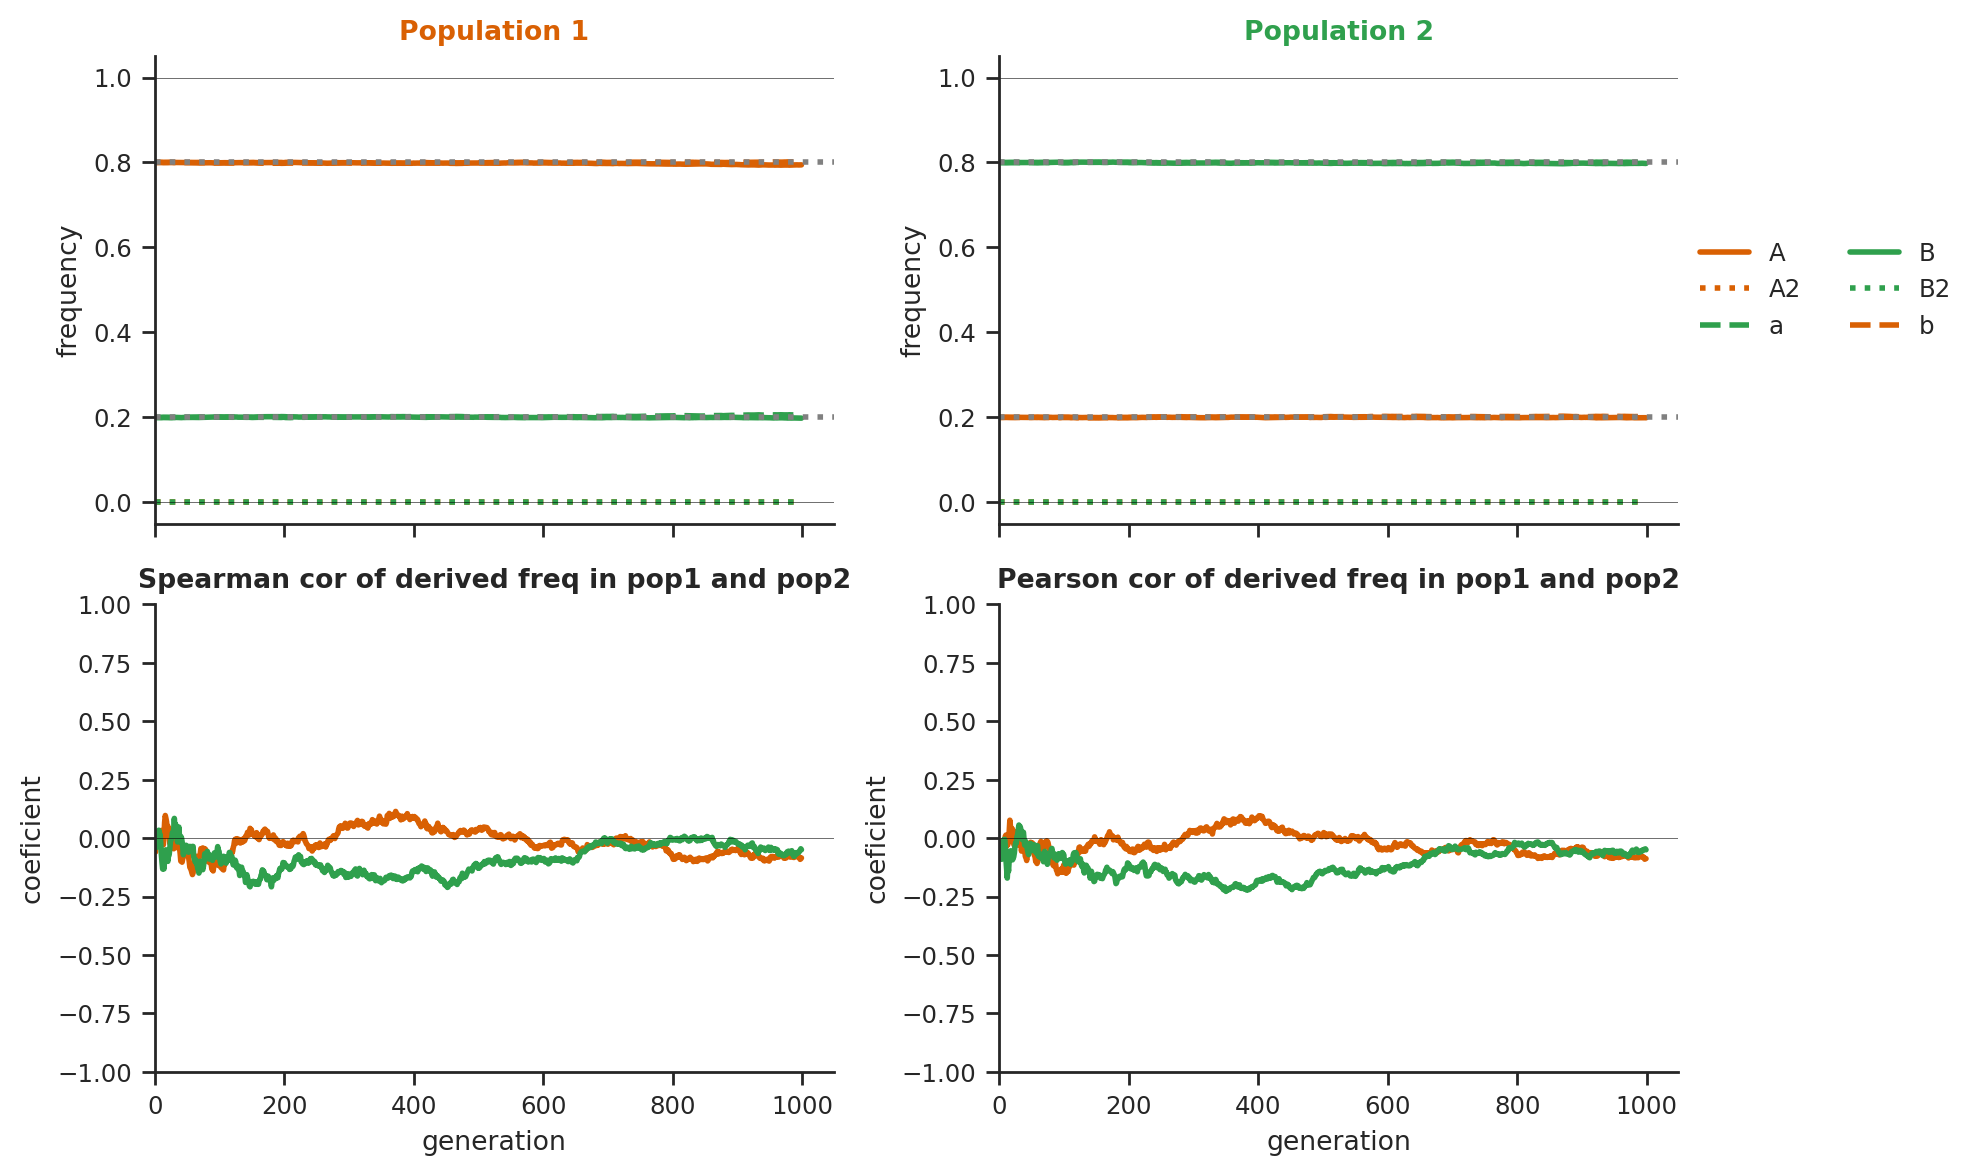

In [23]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0)

---

## Adding gamma distributed s

### BDMI

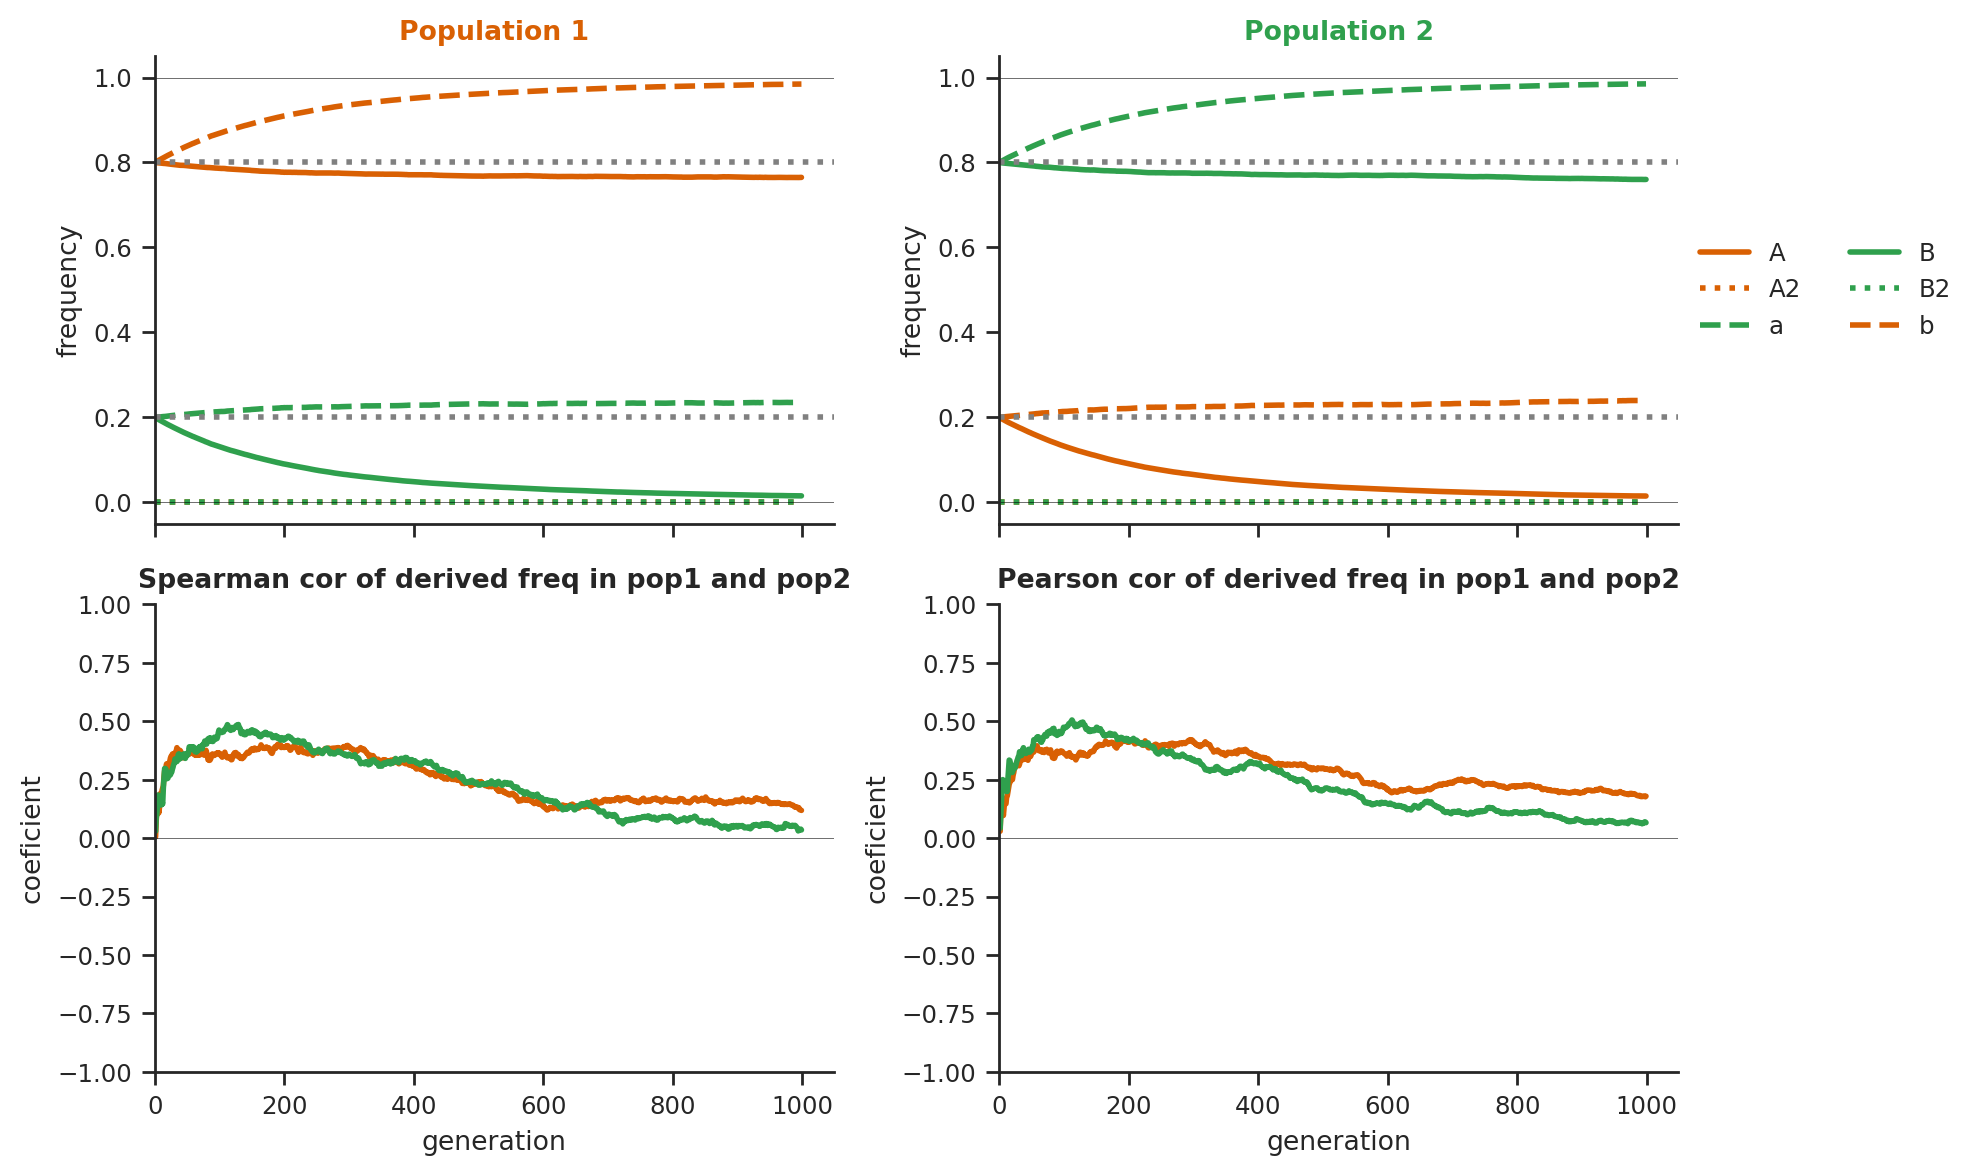

In [24]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=gam_s)

---

## Adding interspersed bdmi

### No BDMI

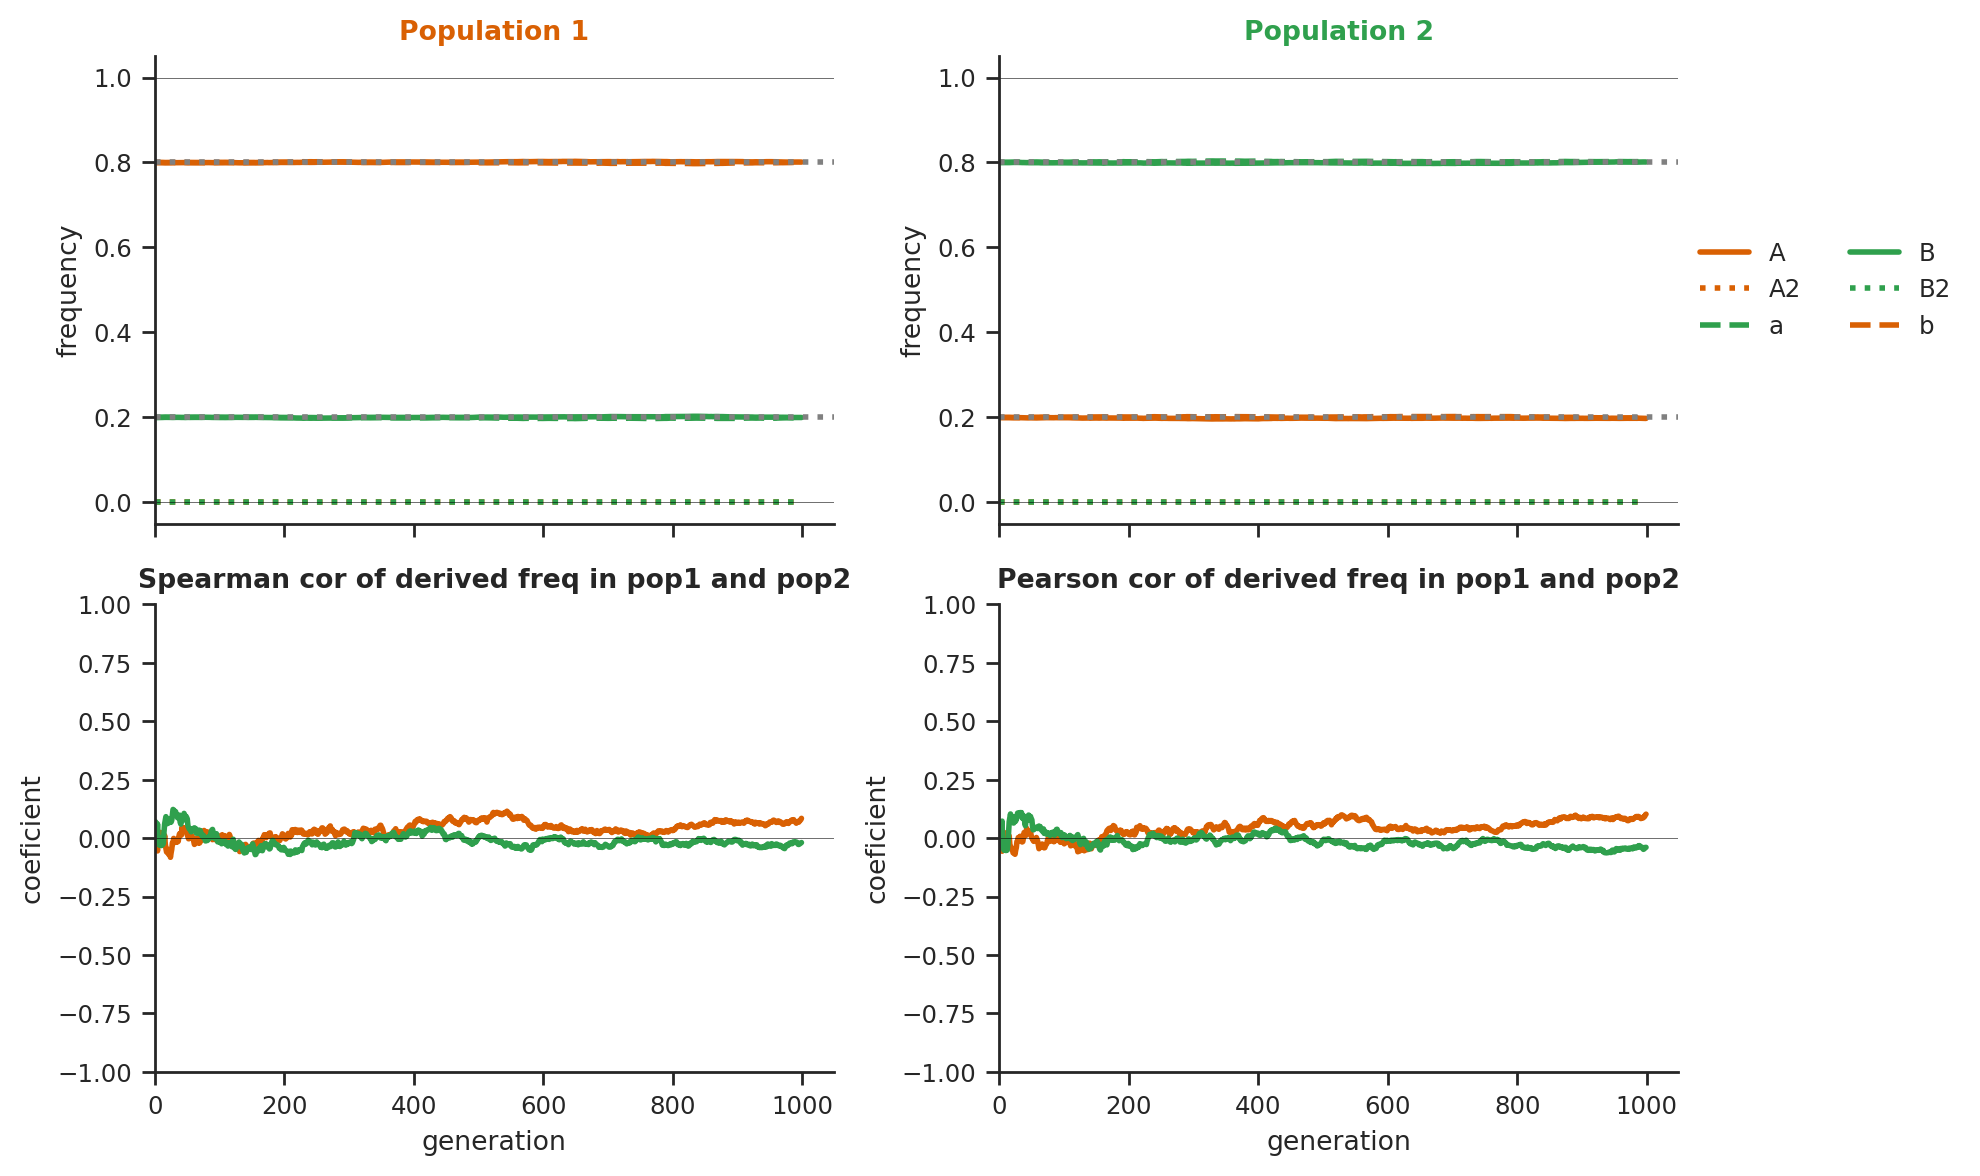

In [25]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0)

---

## Adding interspersed bdmi

### BDMI

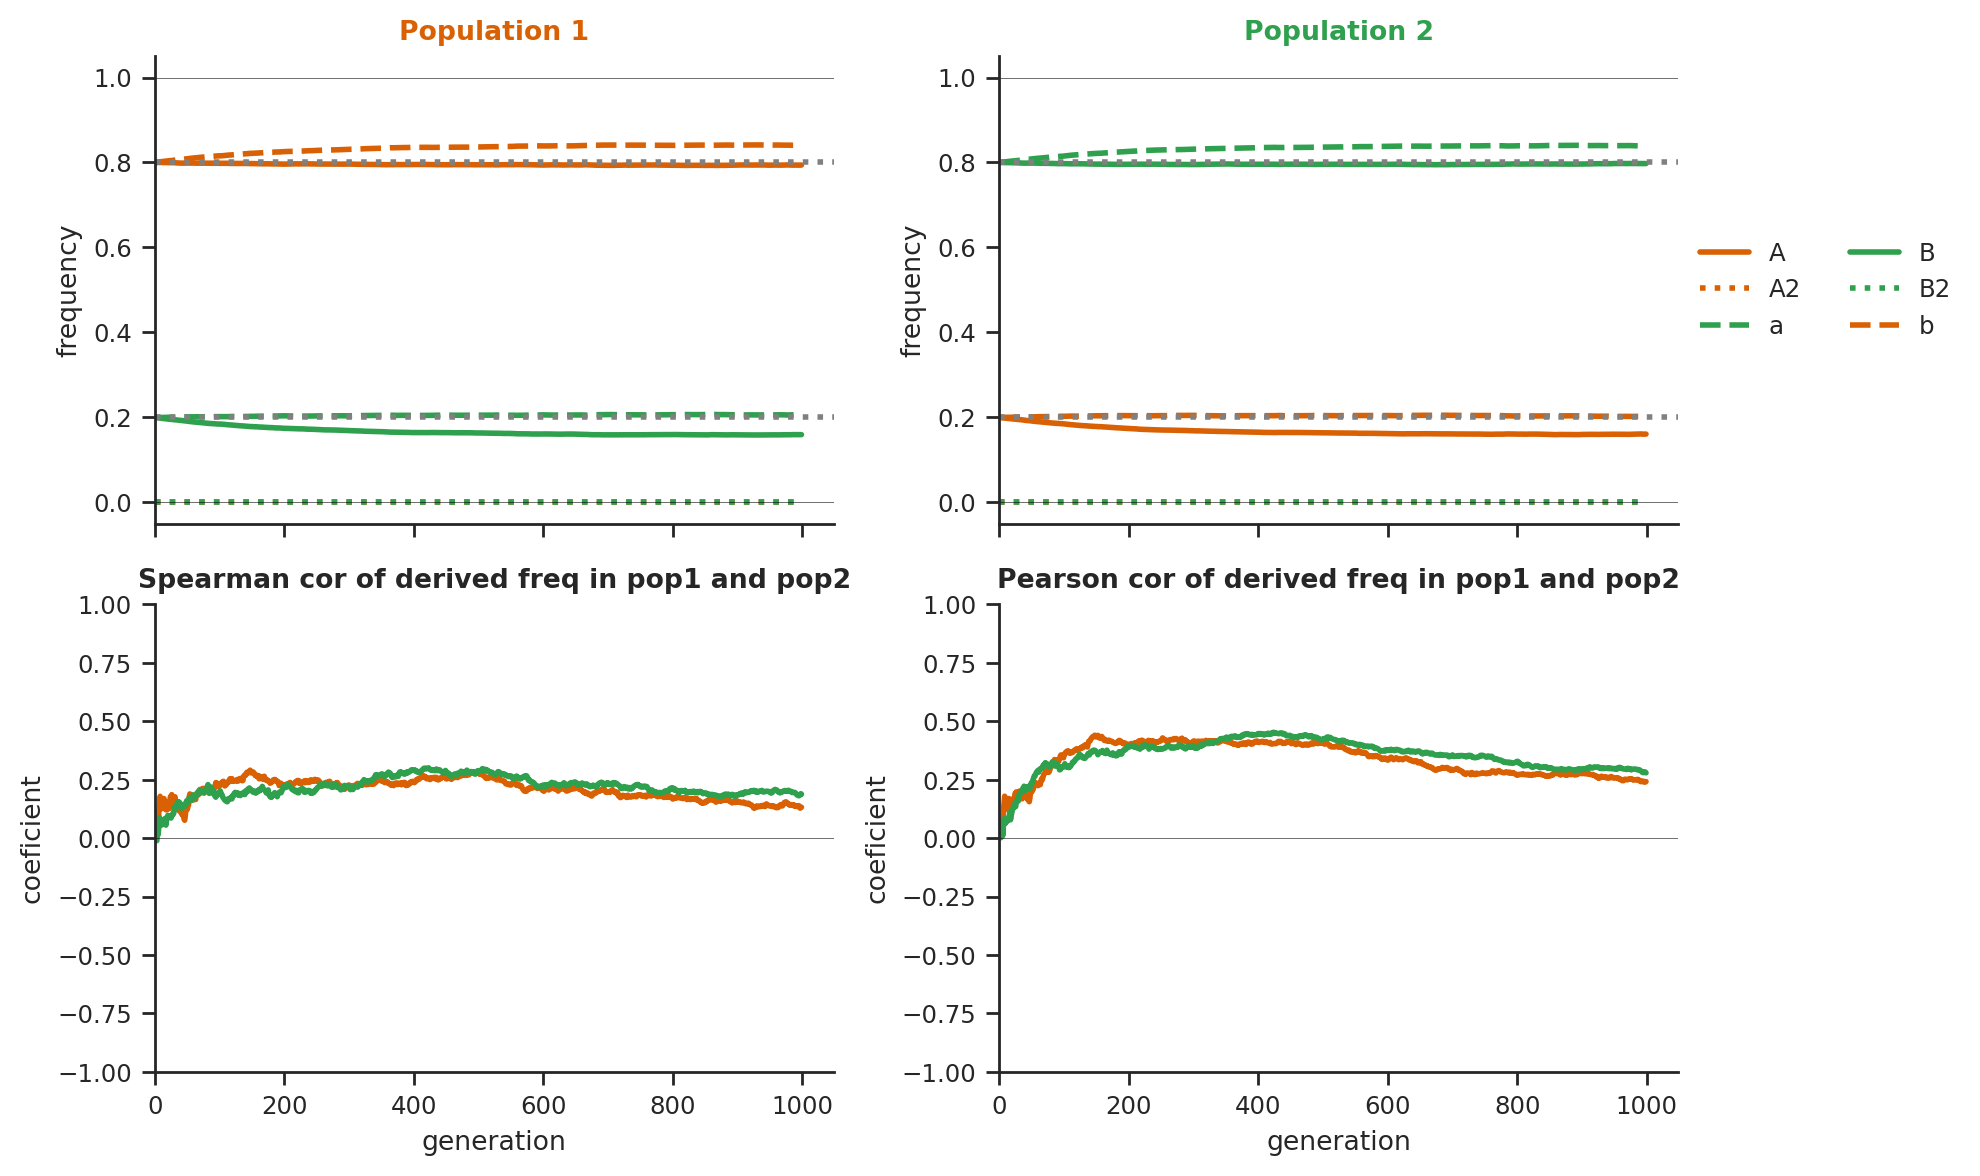

In [26]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=inter_s)

---

## Adding "almost fixed" A and B

### No BDMI

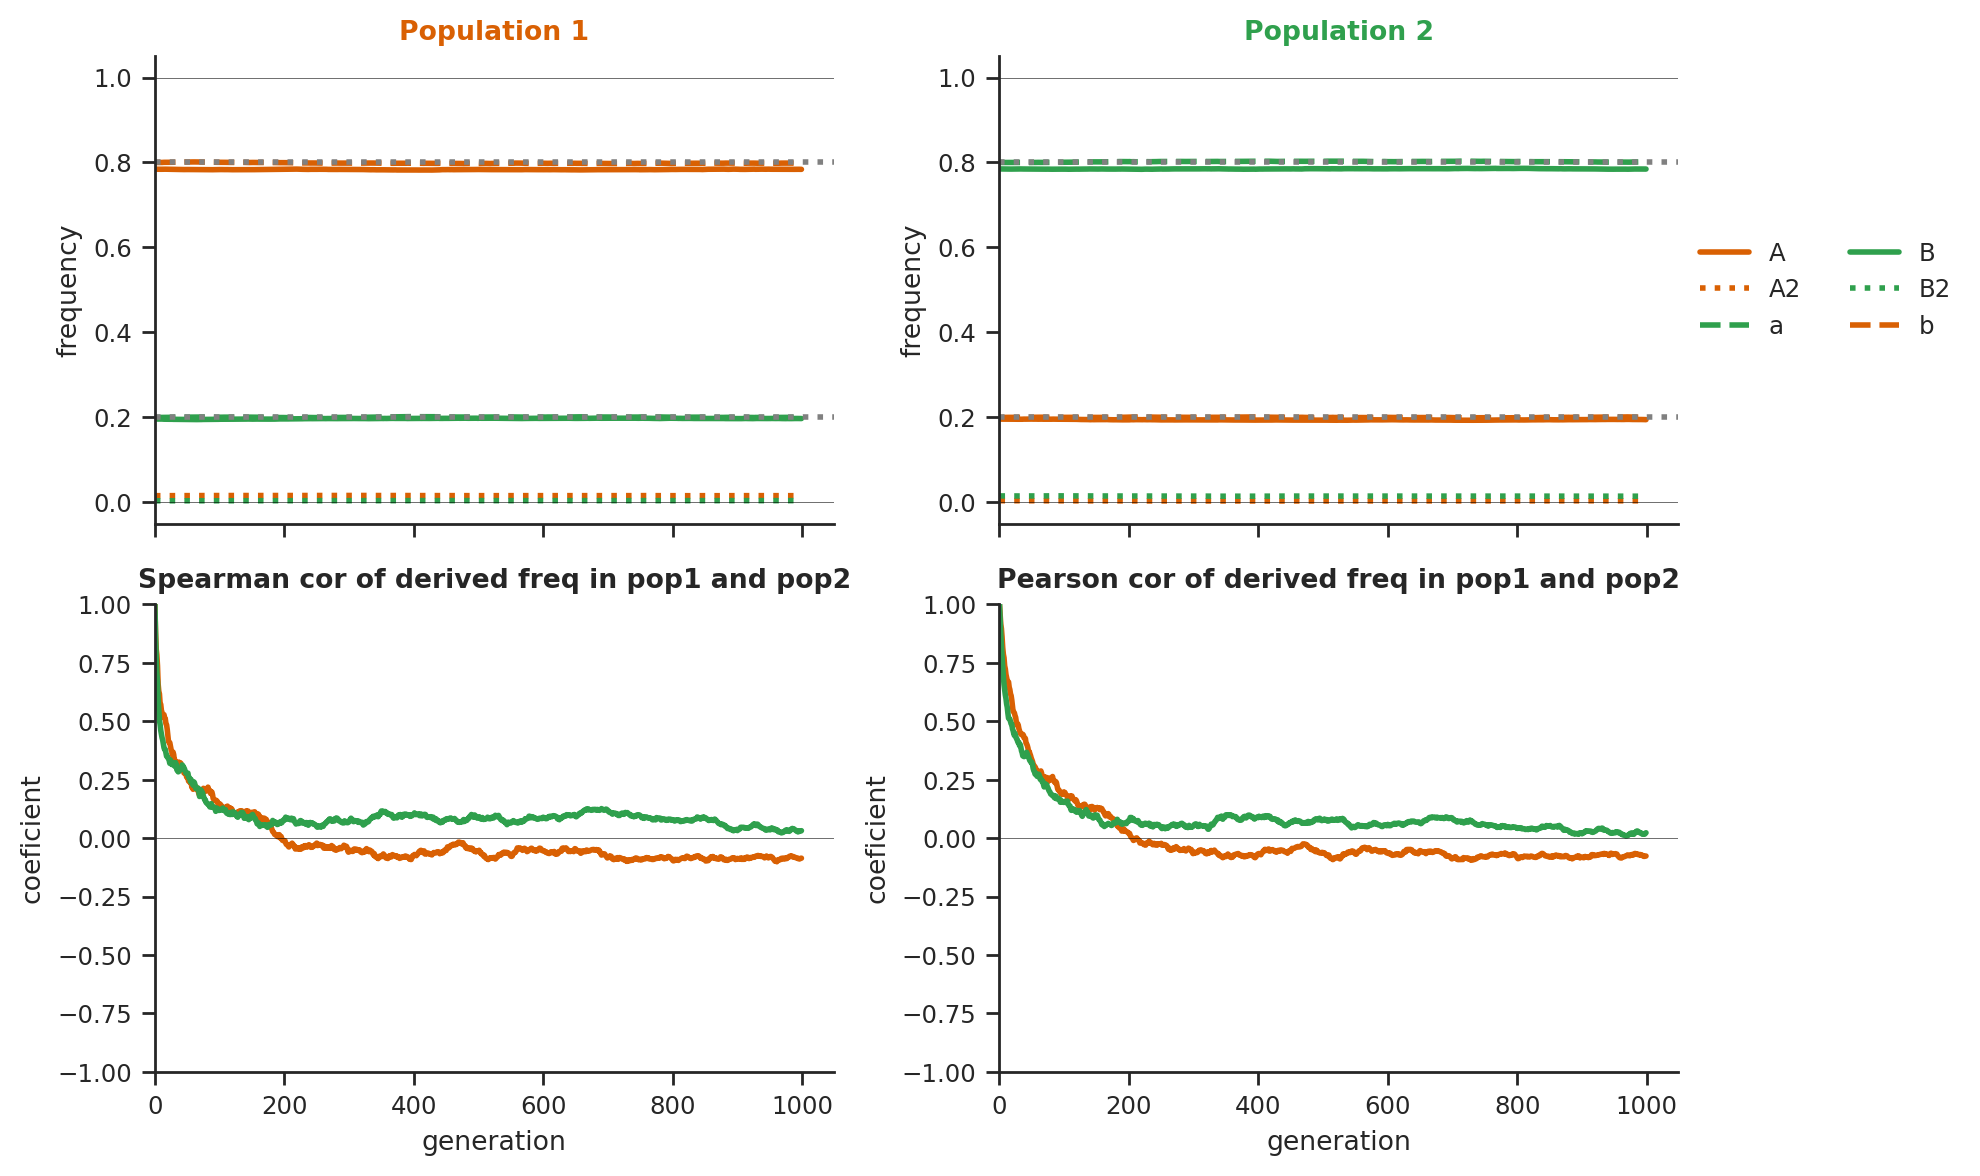

In [27]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0, A2_freq=bfr, B2_freq=bfr)

---

## Adding "almost fixed" A and B

### BDMI

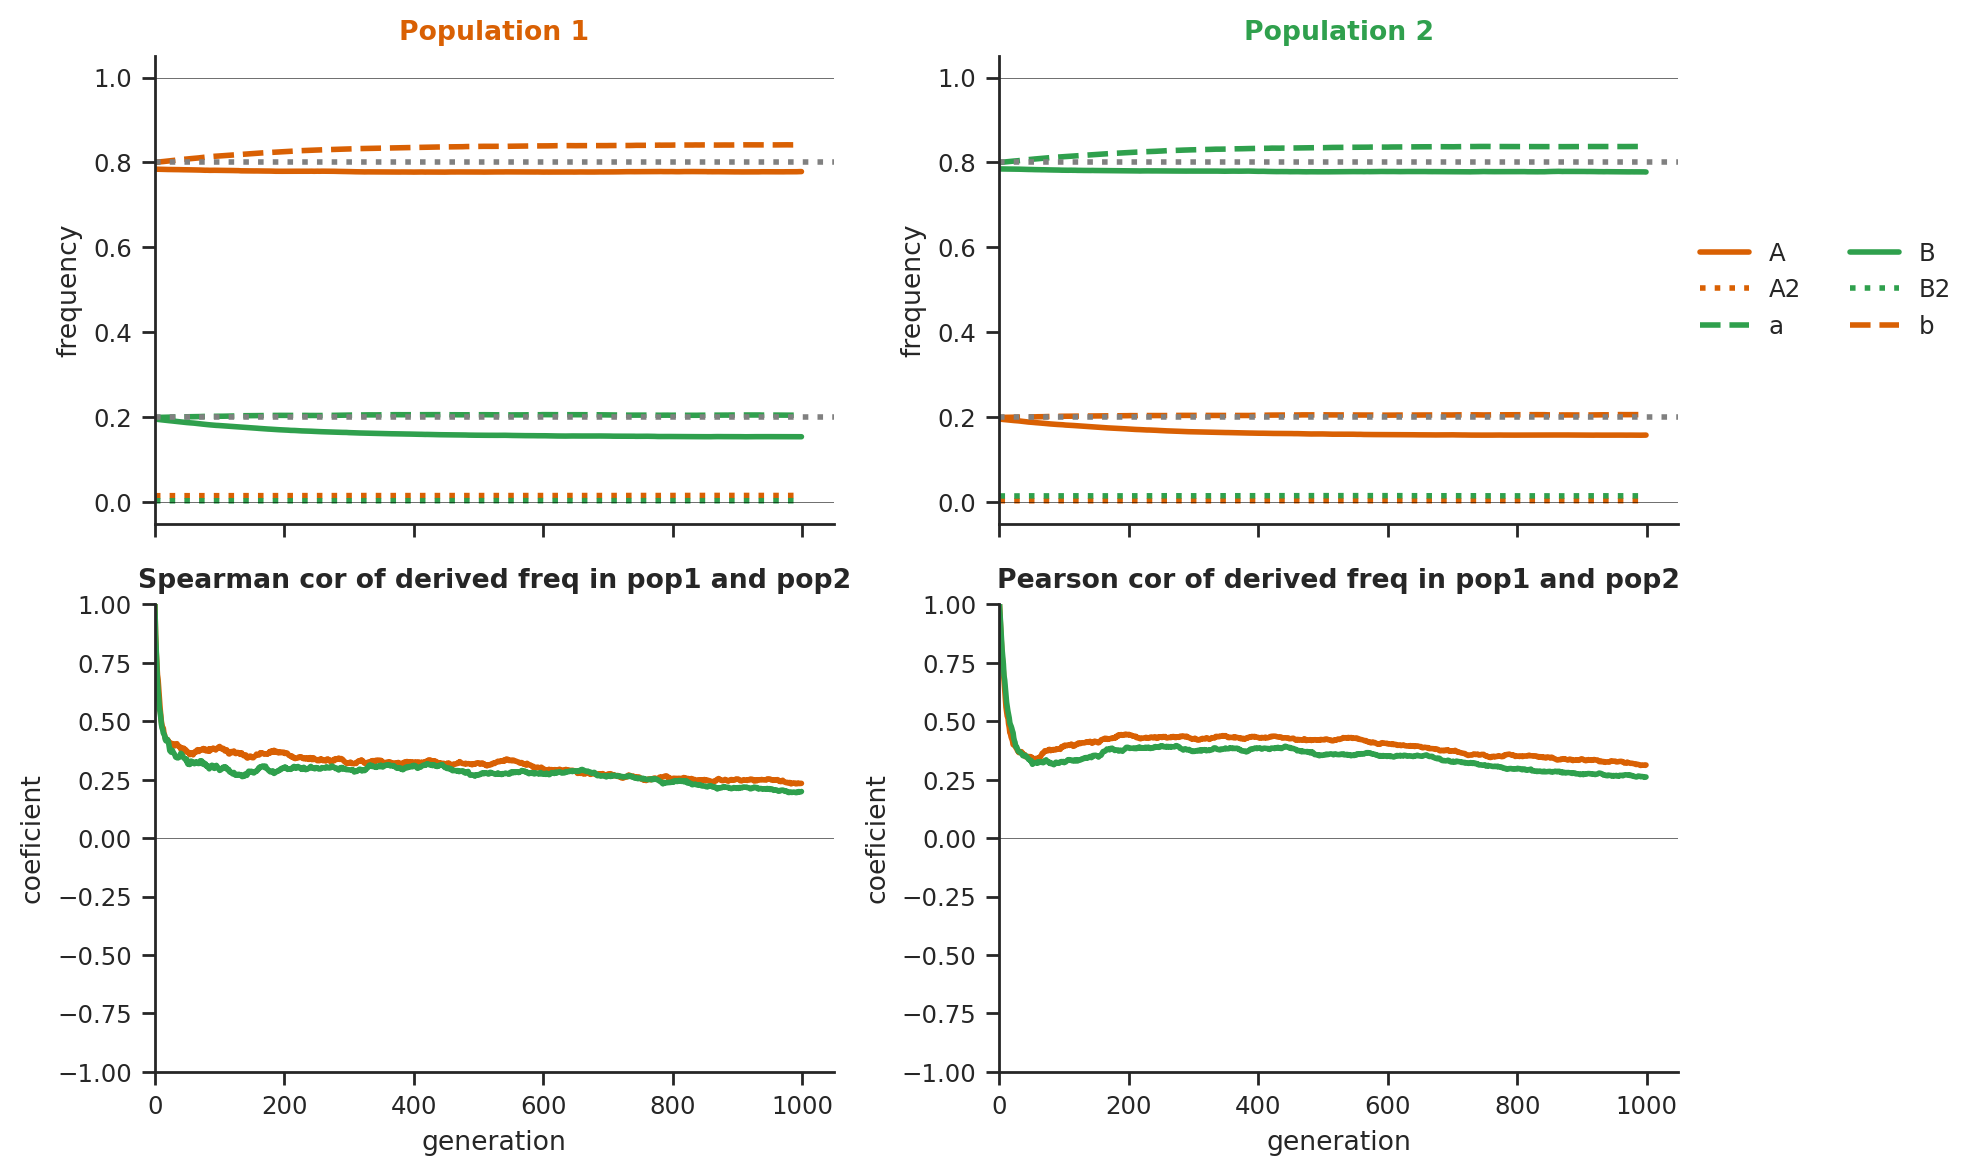

In [28]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=inter_s, A2_freq=bfr, B2_freq=bfr)

---

# Protracted initial pulse

---

## Strong migration in first 100 generations

### No BDMI

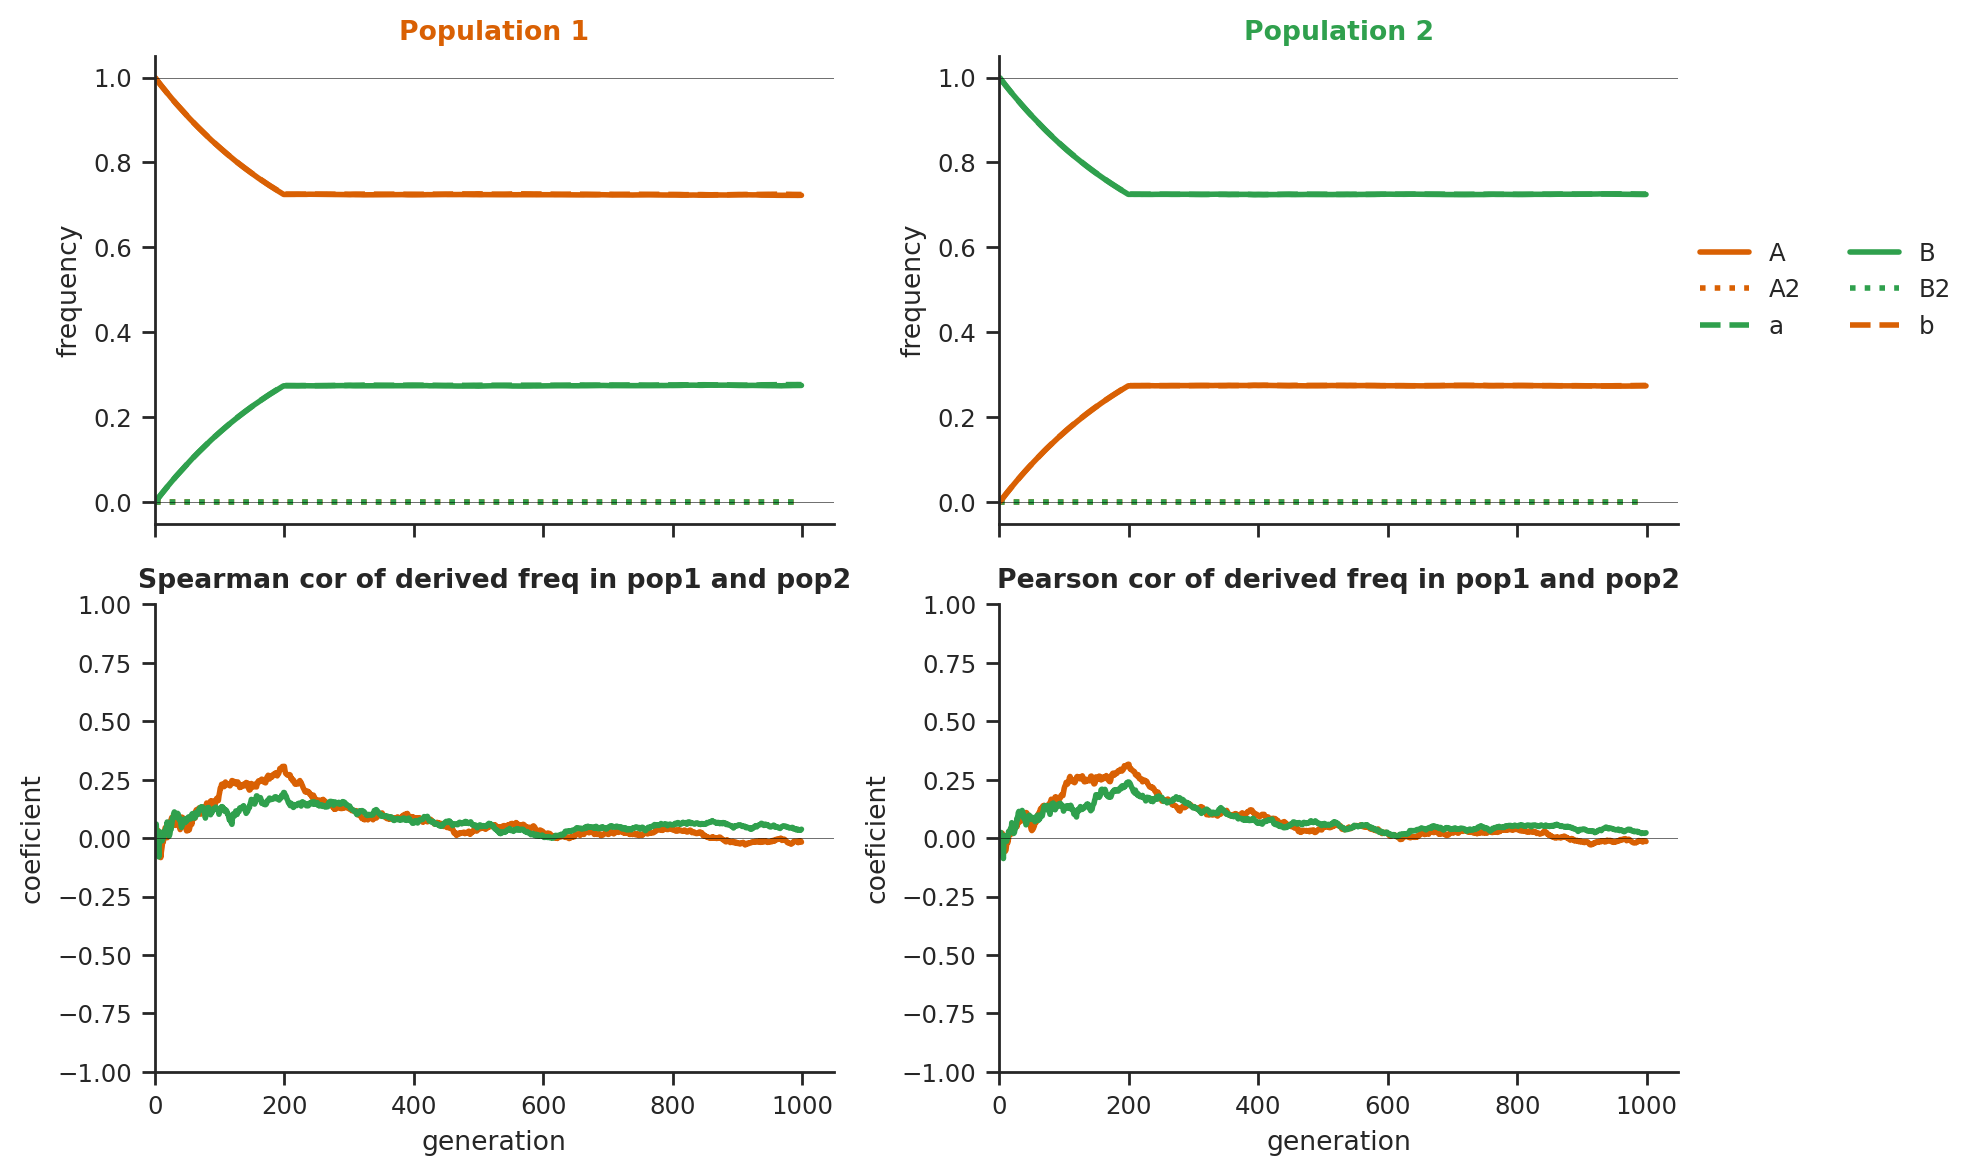

In [29]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, mig_interval=(0, 200), AB_bdmi_s=-0)

---

## Strong migration in first 100 generations

### BDMI

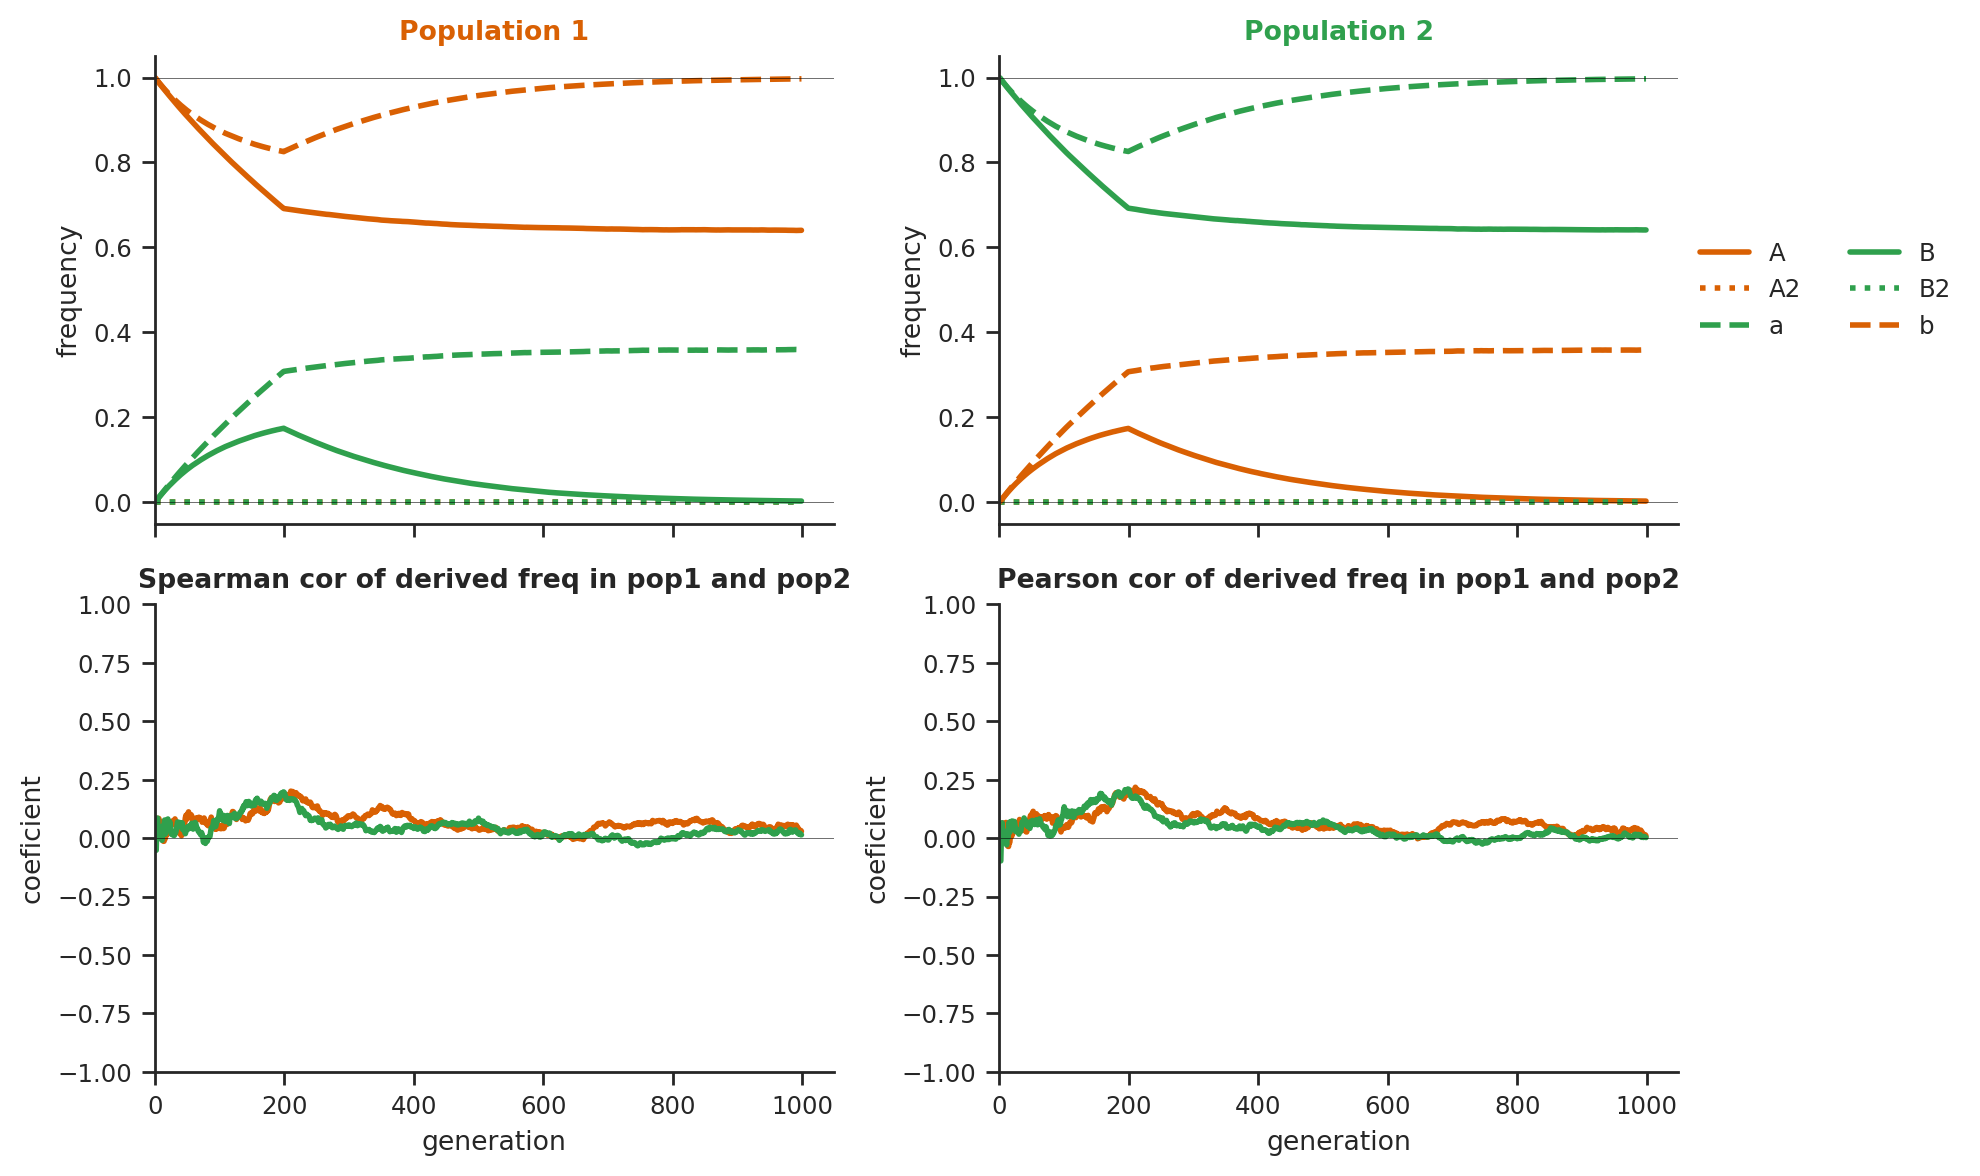

In [30]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, mig_interval=(0, 200), AB_bdmi_s=s)

---

# Ongoing migration

---

## Migration

### No BDMI

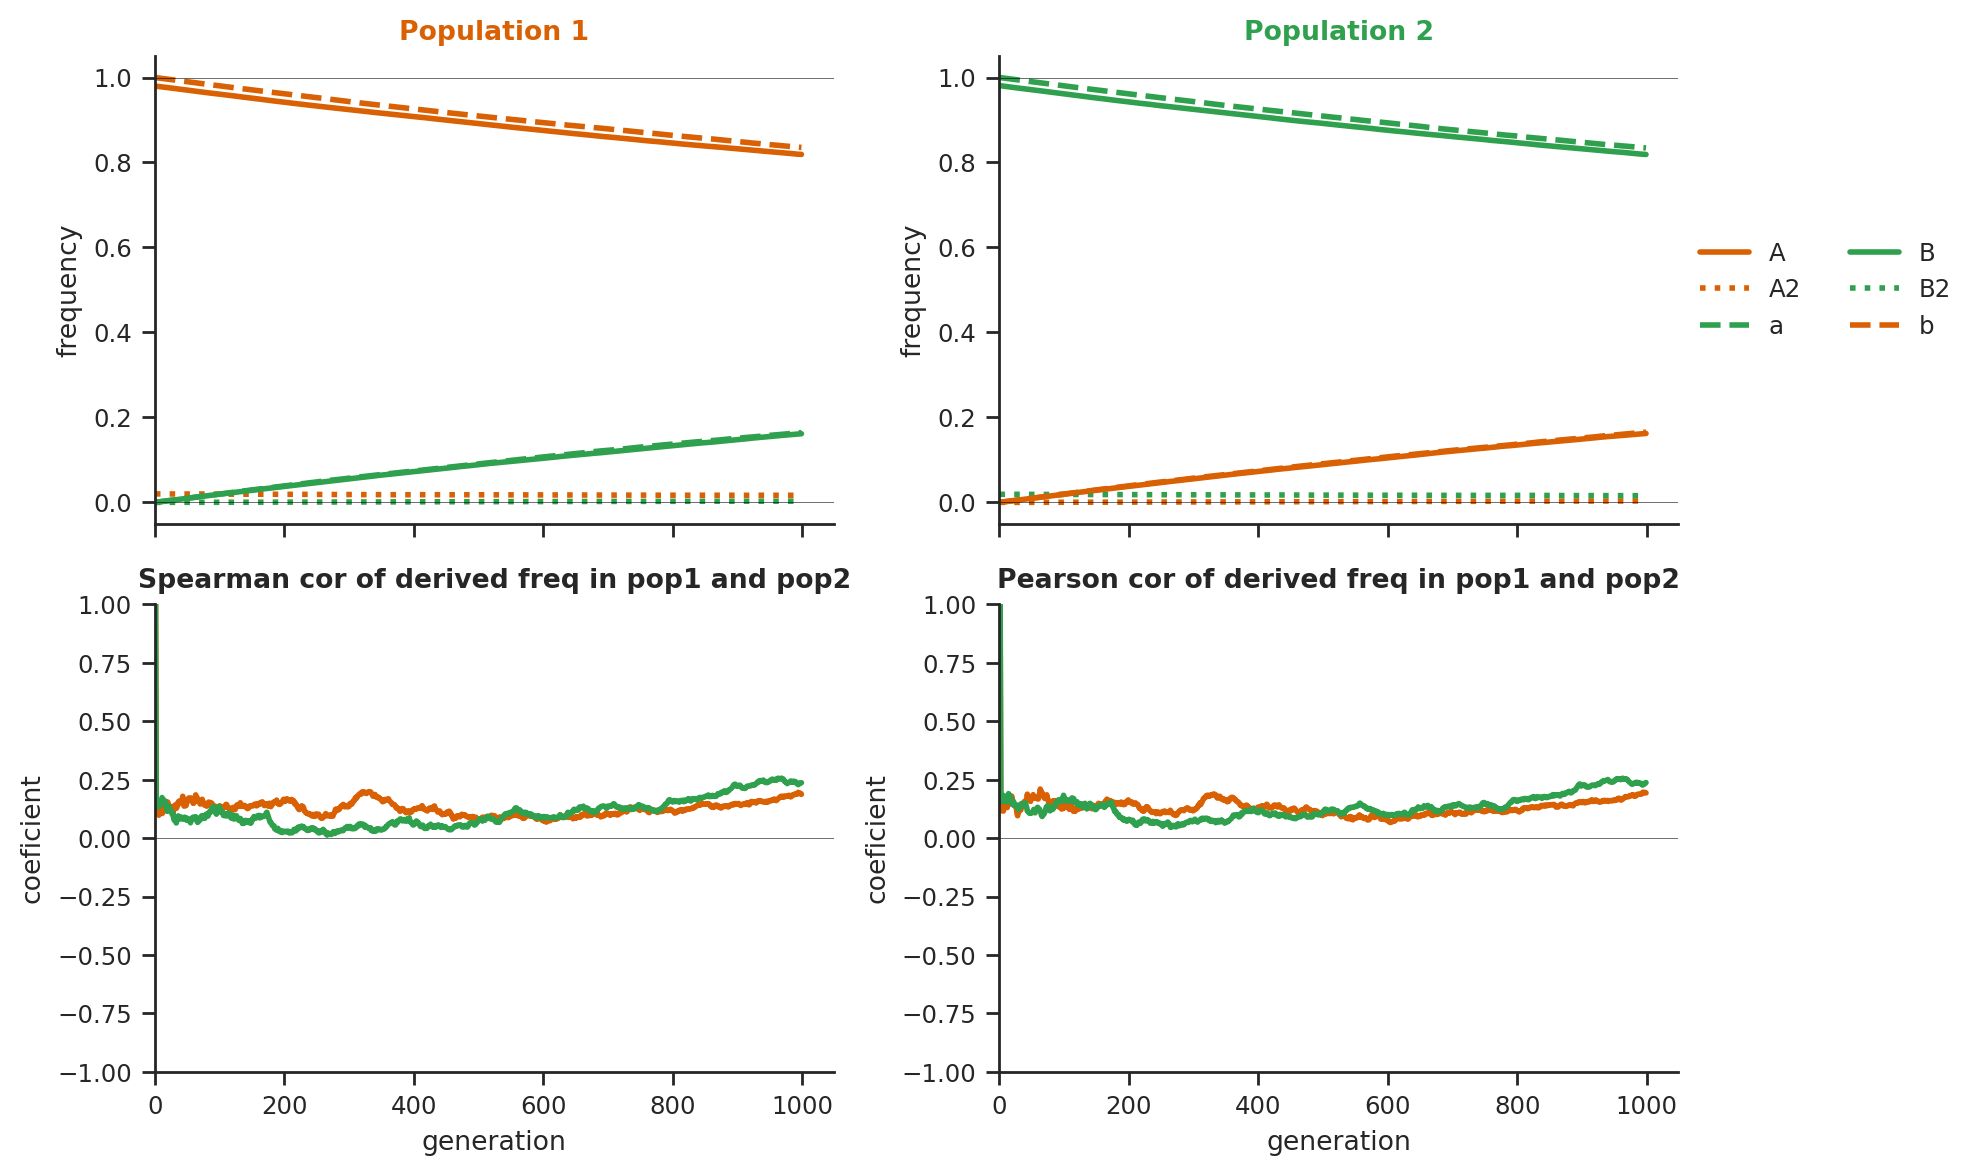

In [31]:
#| echo: true
plot_scenario(samples, M1=10, M2=10, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Migration

### BDMI

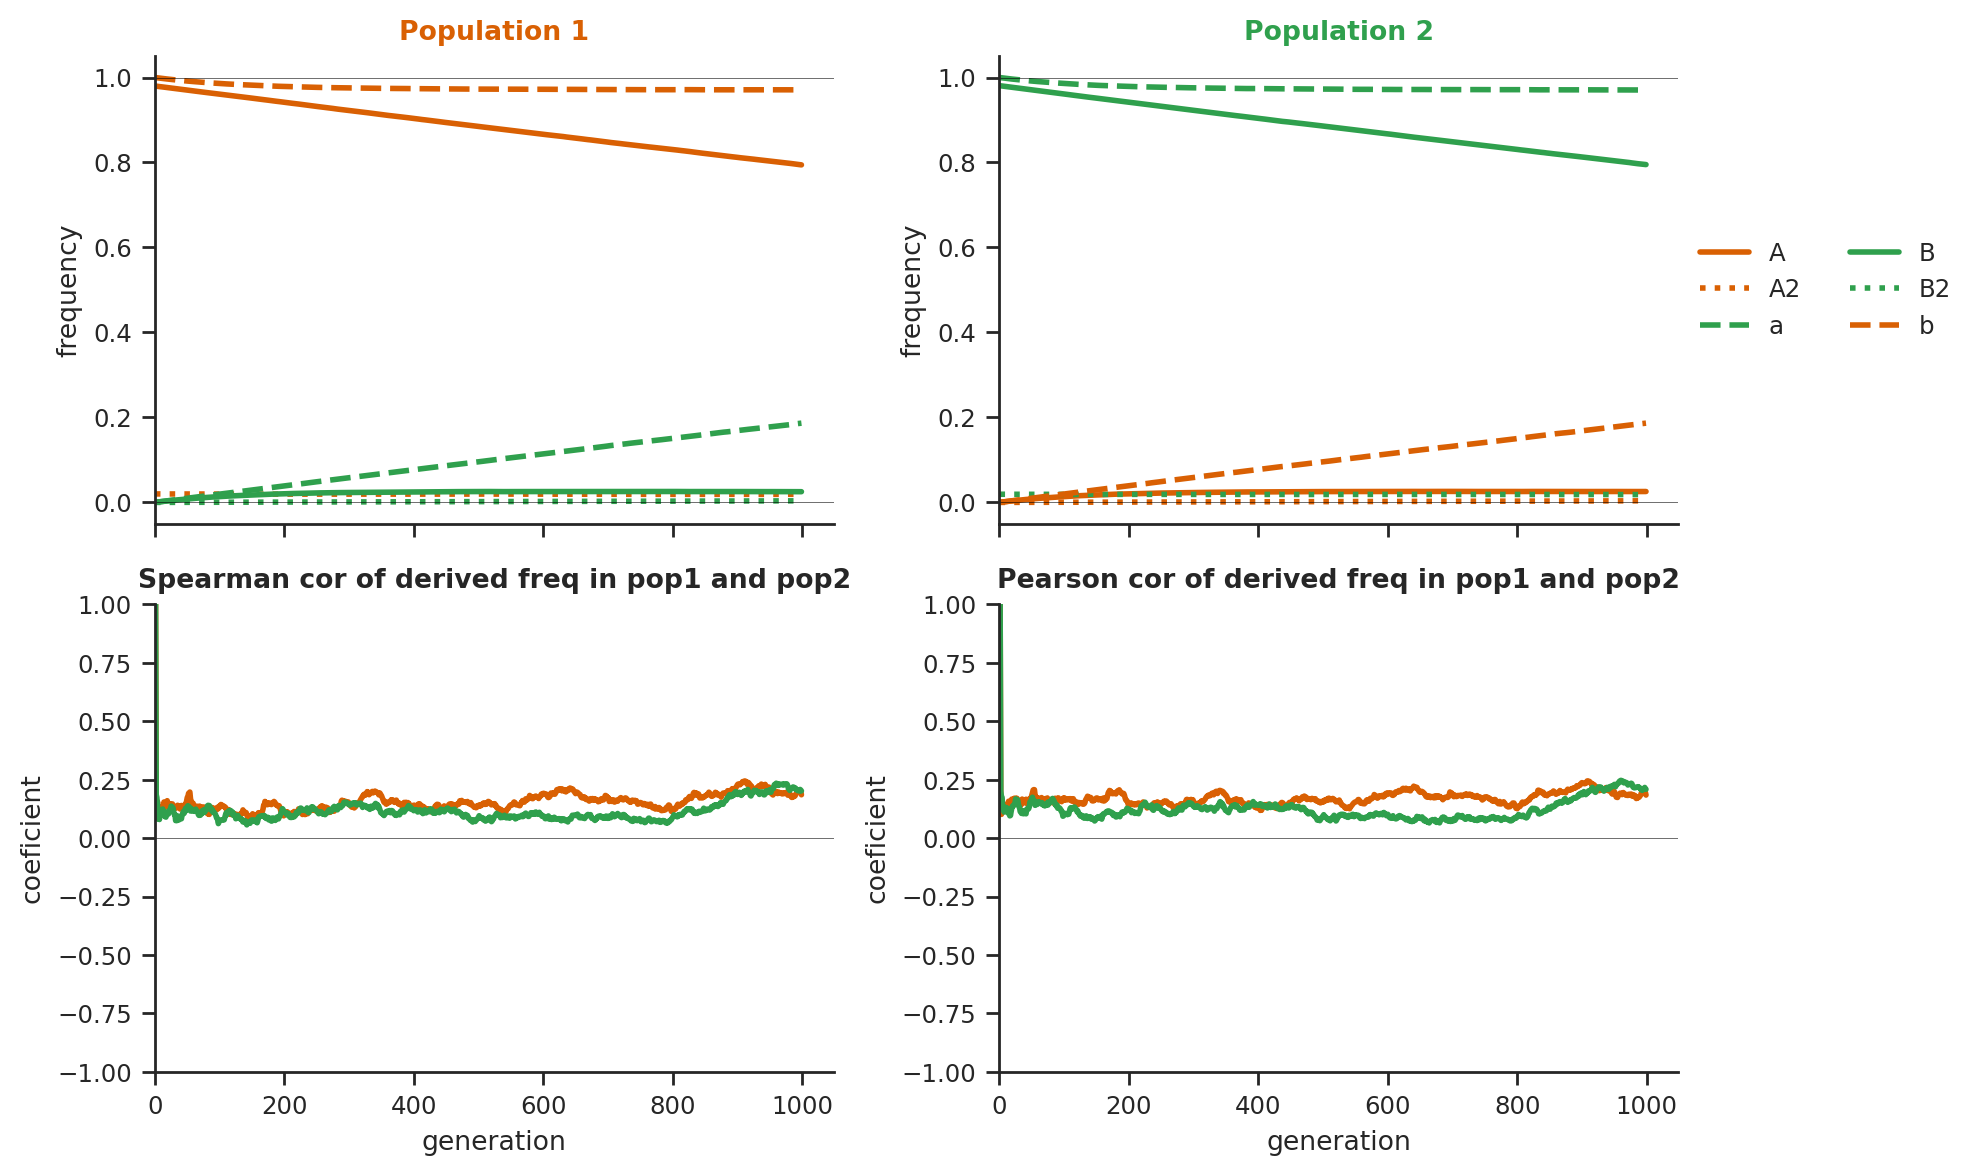

In [32]:
#| echo: true
plot_scenario(samples, M1=10, M2=10, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

## Stronger migration

### No BDMI

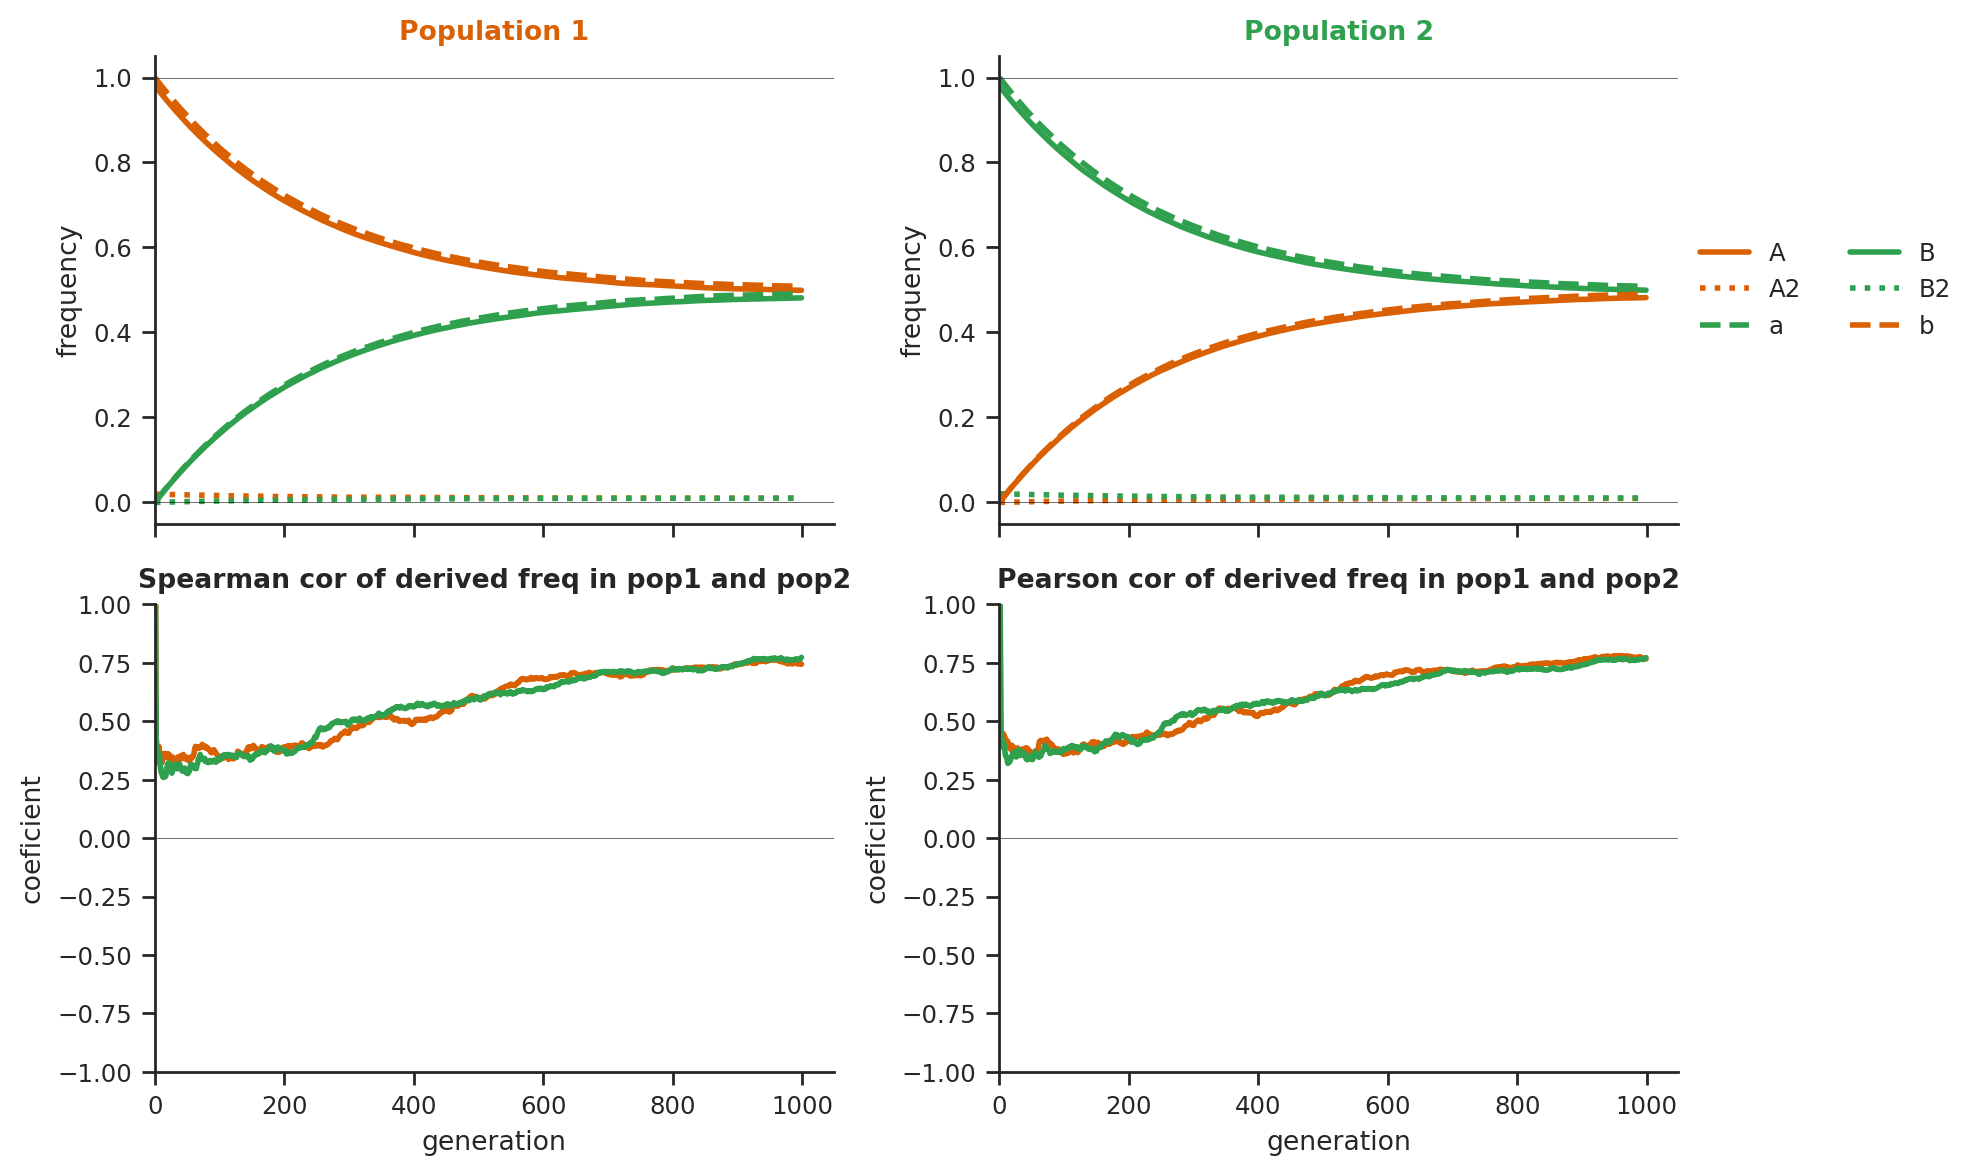

In [33]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Stronger migration

### BDMI

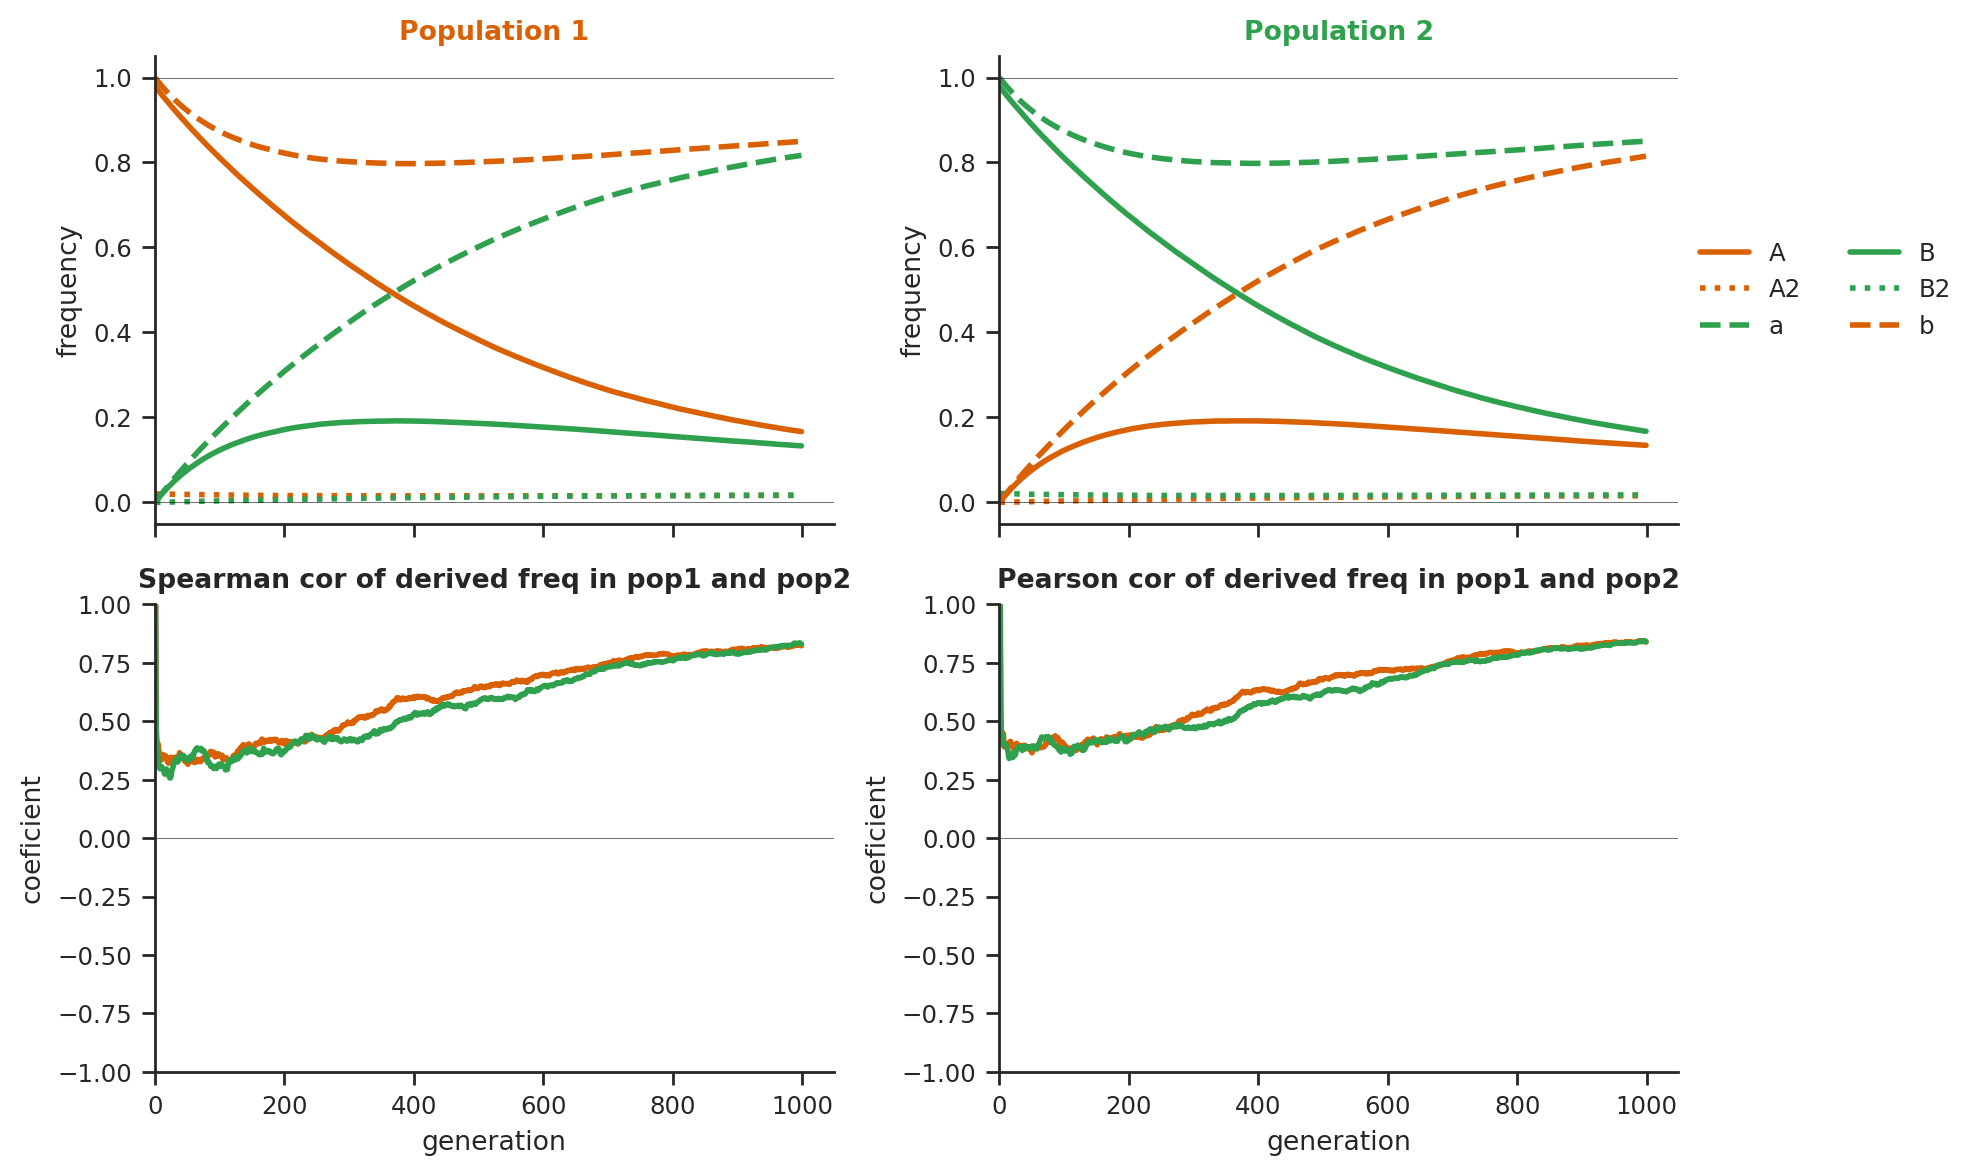

In [34]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

## Allele swapping


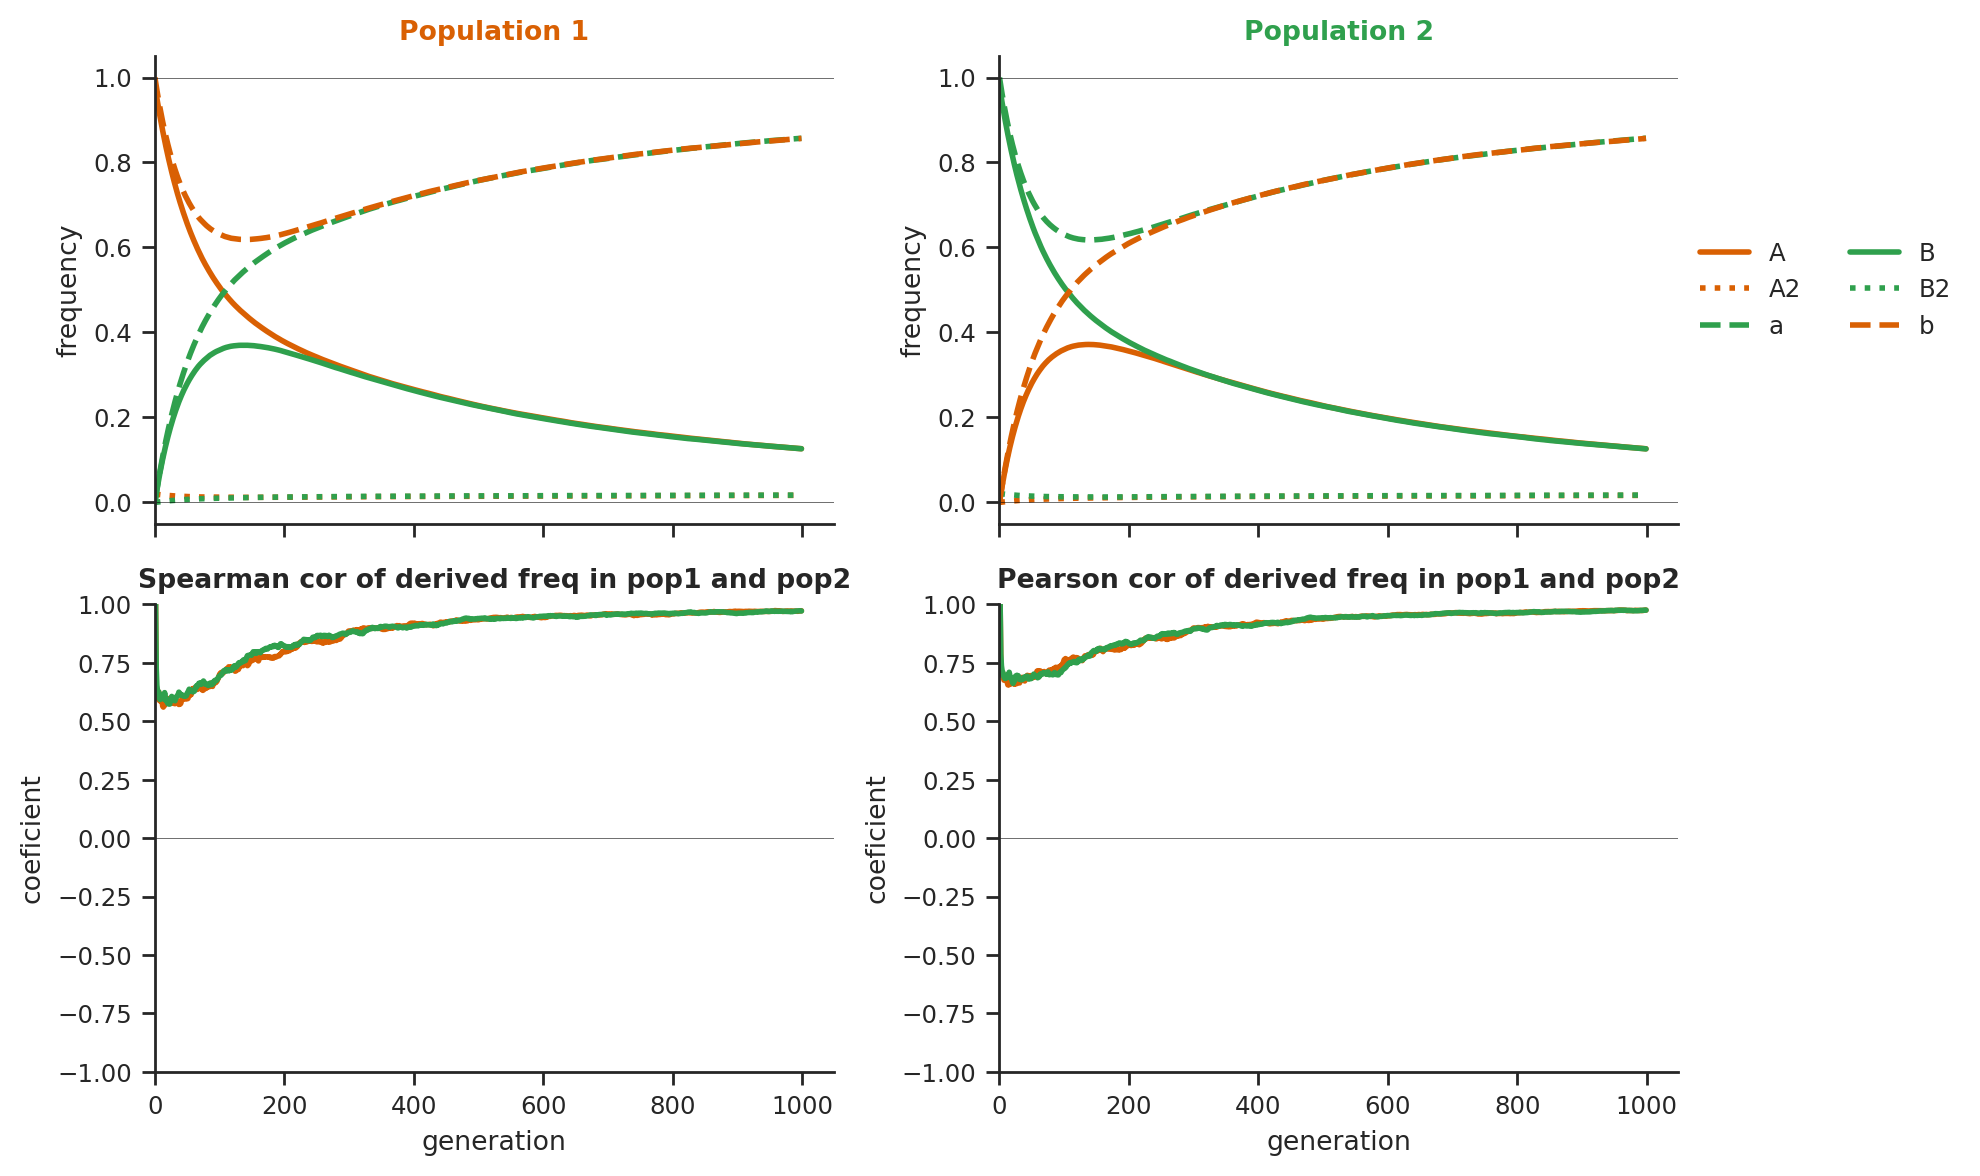

In [35]:
#| echo: true
plot_scenario(samples, M1=500, M2=500, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

# Swamping

---

## Stronger migration

### No BDMI

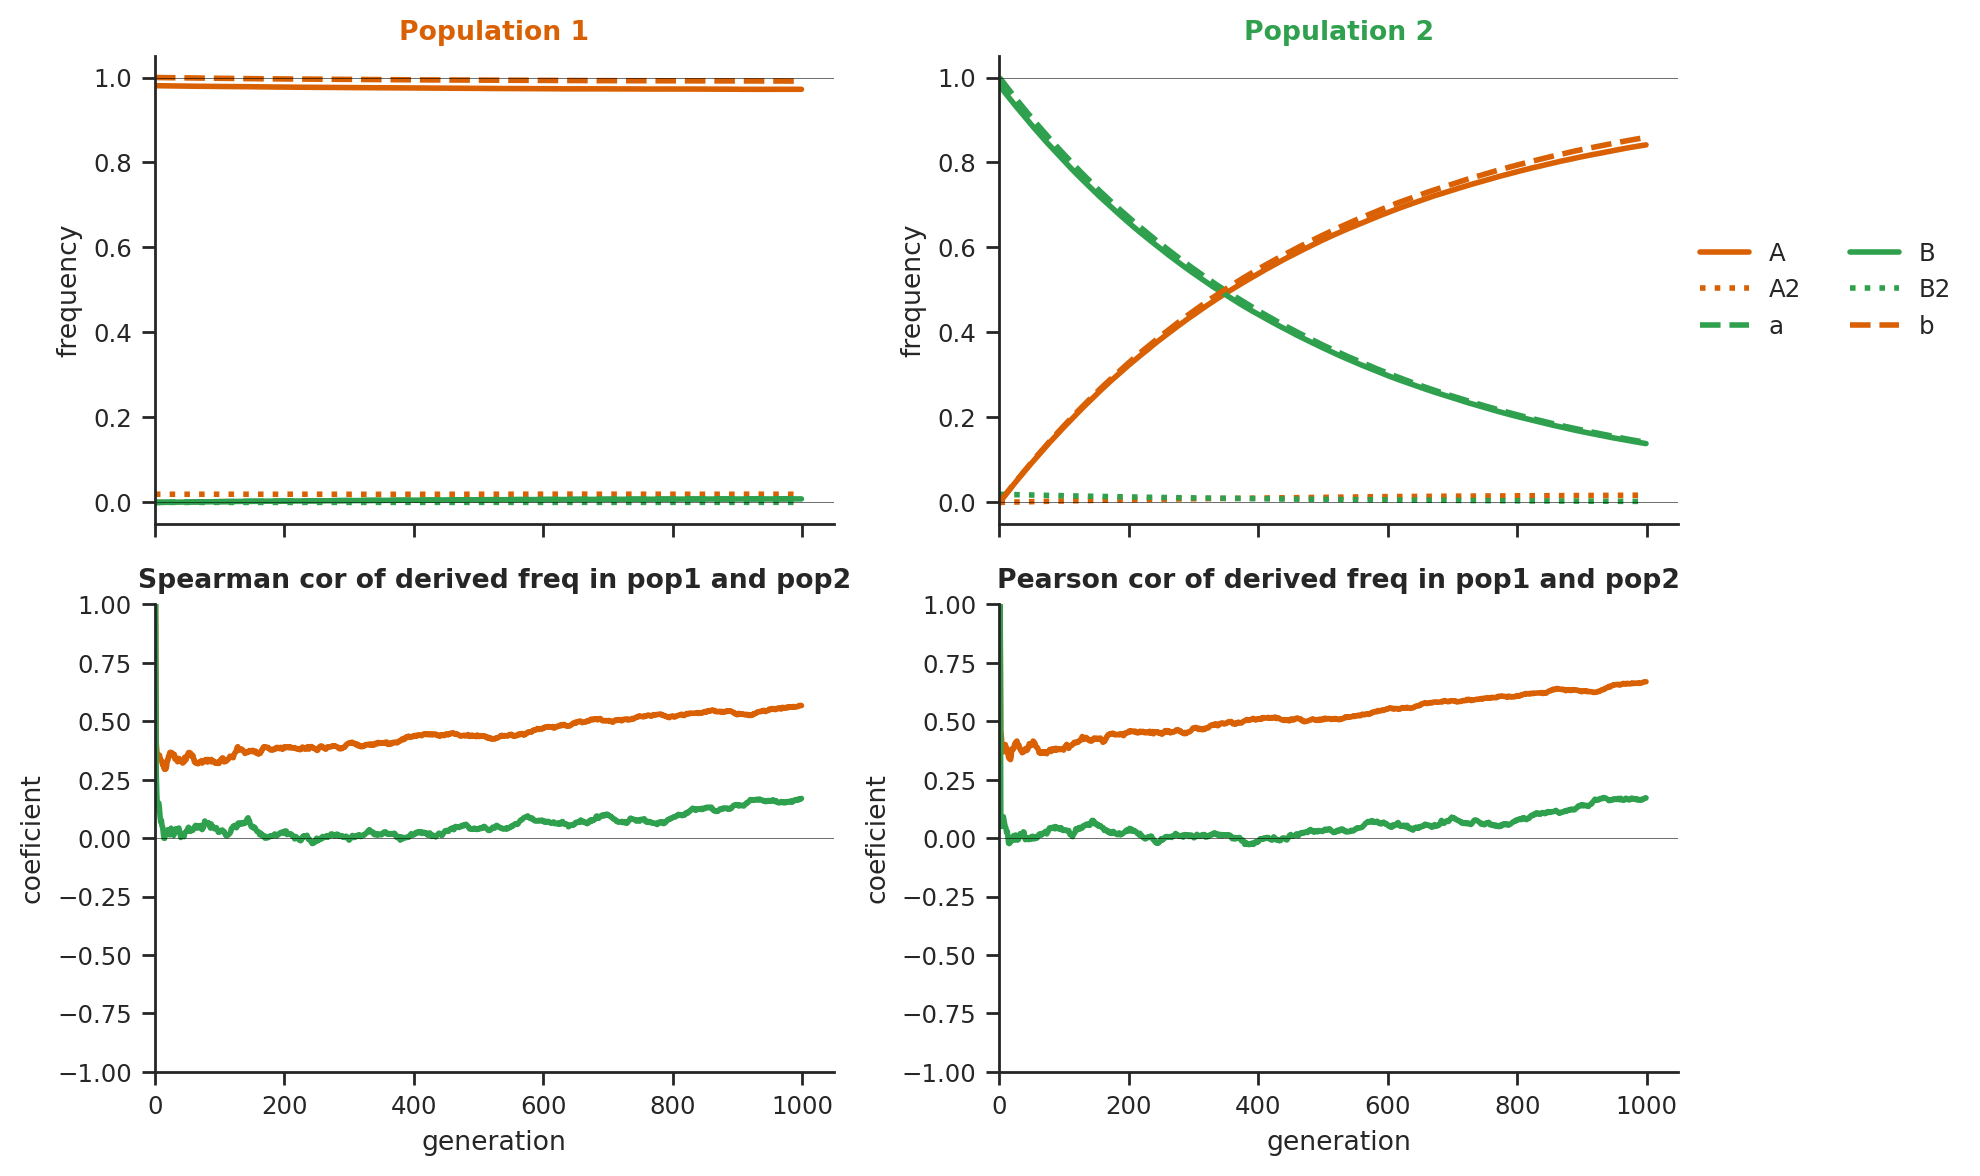

In [36]:
#| echo: true
plot_scenario(samples, M1=1, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Stronger migration

### BDMI

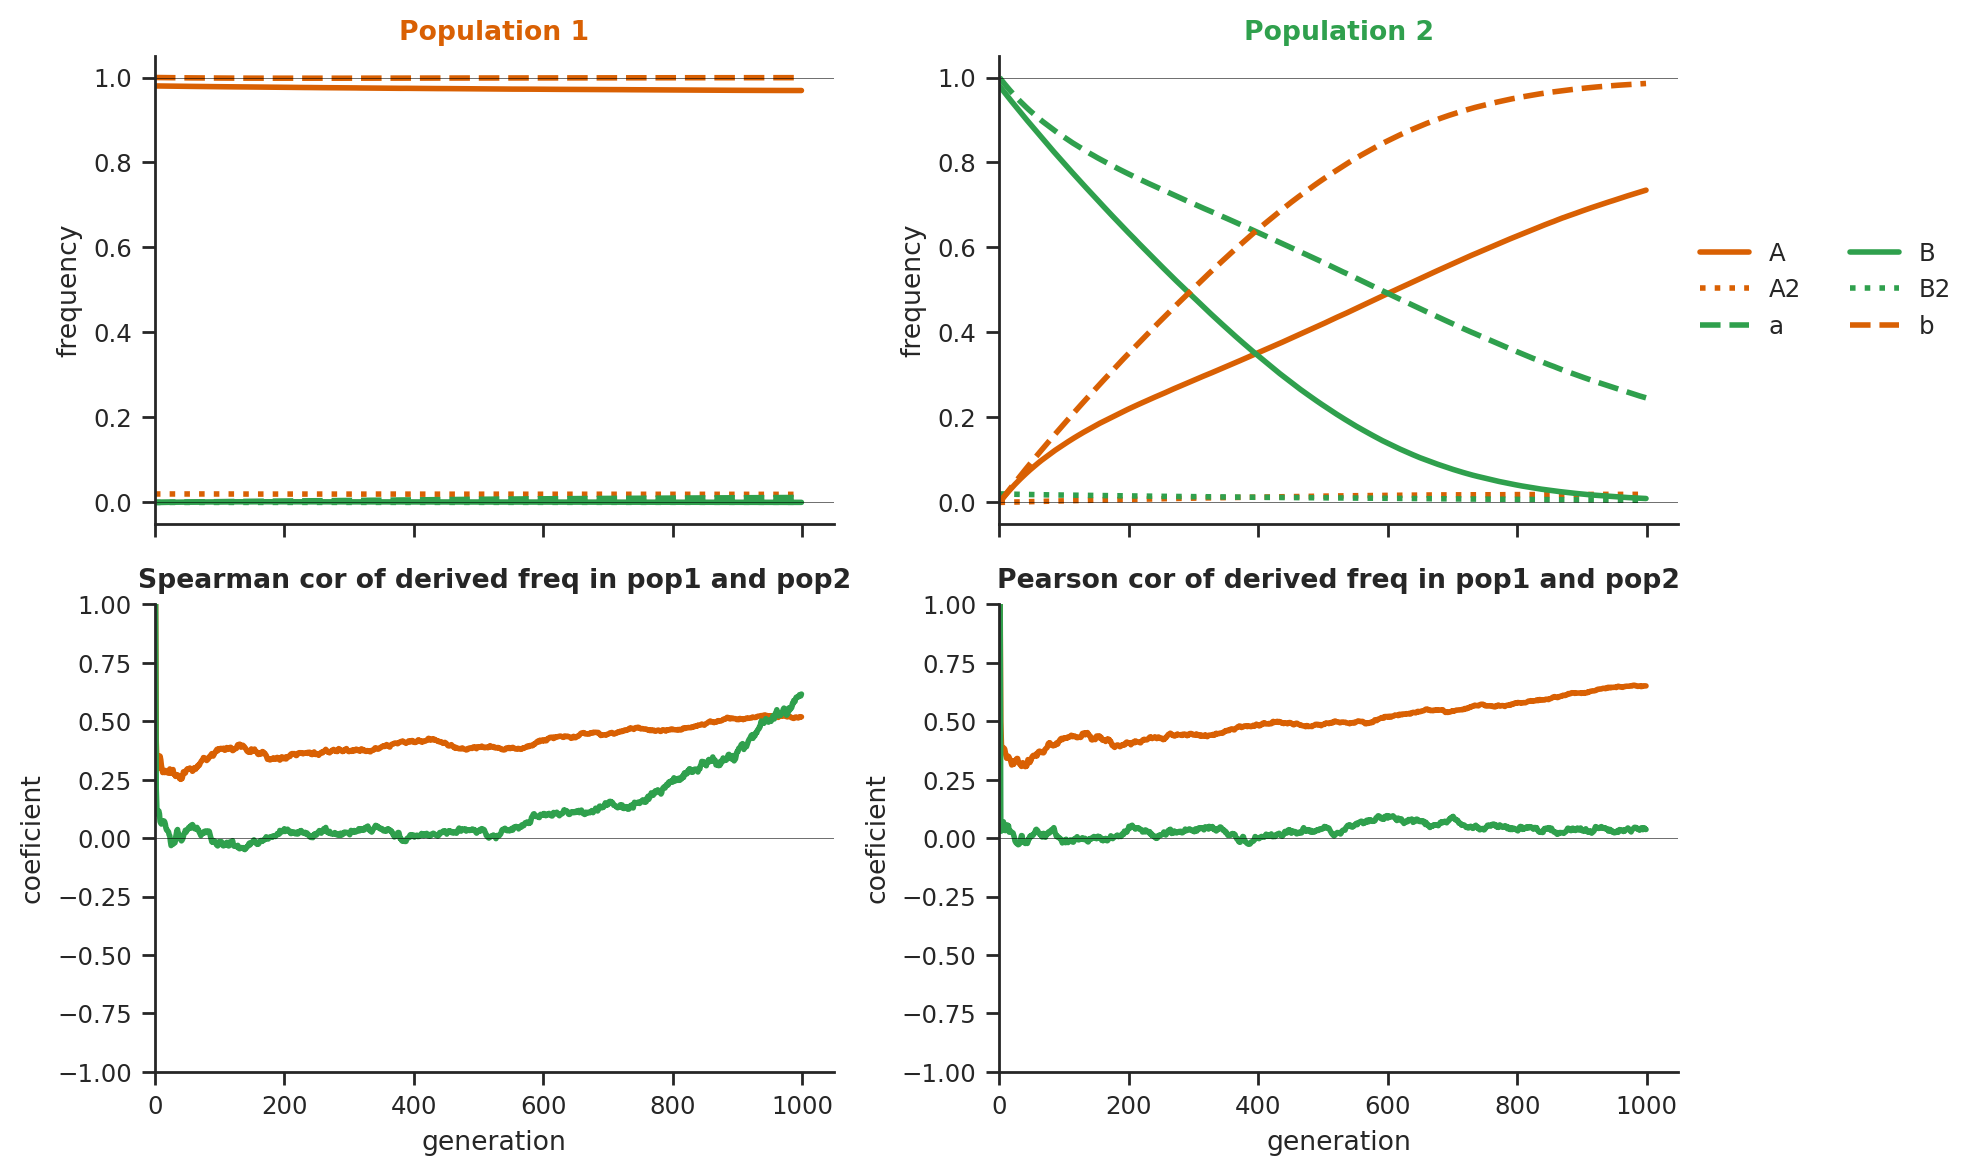

In [37]:
#| echo: true
plot_scenario(samples, M1=1, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)